# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
 data_dir = './data'




"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

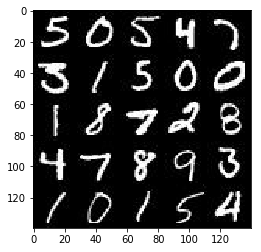

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

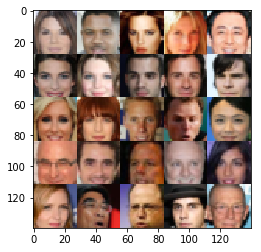

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='Z_Input') 
    learn_rate = tf.placeholder(tf.float32, (None), name='Learning_Rate') 
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    x = images
    alpha = 0.1
    keep_prob = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    keep_prob = 0.9
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape().as_list())
        # 4x4x512 now
        

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        #print(x2.get_shape().as_list())
          # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        #print(x3.get_shape().as_list())
        # 14x14x256 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.get_shape().as_list())
        # 28x28x3 now

        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # FROM DCGAN script
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)  
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2],
                                                   data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    saver = tf.train.Saver()

    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 15
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # rescale the batch_images to (-1,1)  (tanh)
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # print the losses every 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './sess_gen.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2..., step 10 Discriminator Loss: 0.4984... Generator Loss: 1.8916
Epoch 1/2..., step 20 Discriminator Loss: 0.5149... Generator Loss: 1.3934
Epoch 1/2..., step 30 Discriminator Loss: 1.2700... Generator Loss: 0.6844
Epoch 1/2..., step 40 Discriminator Loss: 0.8117... Generator Loss: 1.4349
Epoch 1/2..., step 50 Discriminator Loss: 1.1056... Generator Loss: 0.6861
Epoch 1/2..., step 60 Discriminator Loss: 1.1560... Generator Loss: 0.6989
Epoch 1/2..., step 70 Discriminator Loss: 1.3519... Generator Loss: 0.5639
Epoch 1/2..., step 80 Discriminator Loss: 1.2290... Generator Loss: 0.6781
Epoch 1/2..., step 90 Discriminator Loss: 1.2221... Generator Loss: 0.6485
Epoch 1/2..., step 100 Discriminator Loss: 1.2742... Generator Loss: 0.6657


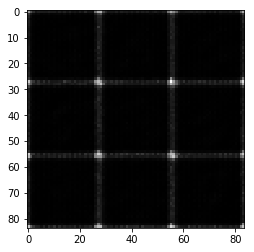

Epoch 1/2..., step 110 Discriminator Loss: 1.2398... Generator Loss: 0.8385
Epoch 1/2..., step 120 Discriminator Loss: 1.3055... Generator Loss: 1.2607
Epoch 1/2..., step 130 Discriminator Loss: 1.2379... Generator Loss: 0.7433
Epoch 1/2..., step 140 Discriminator Loss: 1.3903... Generator Loss: 0.5017
Epoch 1/2..., step 150 Discriminator Loss: 1.0343... Generator Loss: 0.8777
Epoch 1/2..., step 160 Discriminator Loss: 1.0516... Generator Loss: 0.7551
Epoch 1/2..., step 170 Discriminator Loss: 1.2068... Generator Loss: 1.0094
Epoch 1/2..., step 180 Discriminator Loss: 0.9457... Generator Loss: 0.9802
Epoch 1/2..., step 190 Discriminator Loss: 0.9628... Generator Loss: 0.9182
Epoch 1/2..., step 200 Discriminator Loss: 1.1289... Generator Loss: 0.6566


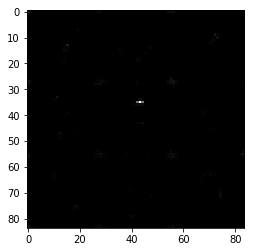

Epoch 1/2..., step 210 Discriminator Loss: 1.0730... Generator Loss: 0.6617
Epoch 1/2..., step 220 Discriminator Loss: 0.9298... Generator Loss: 0.9097
Epoch 1/2..., step 230 Discriminator Loss: 0.8197... Generator Loss: 1.1029
Epoch 1/2..., step 240 Discriminator Loss: 1.0291... Generator Loss: 1.7936
Epoch 1/2..., step 250 Discriminator Loss: 0.9219... Generator Loss: 1.1702
Epoch 1/2..., step 260 Discriminator Loss: 0.6434... Generator Loss: 1.3023
Epoch 1/2..., step 270 Discriminator Loss: 0.8671... Generator Loss: 1.6895
Epoch 1/2..., step 280 Discriminator Loss: 0.8633... Generator Loss: 0.9294
Epoch 1/2..., step 290 Discriminator Loss: 0.6481... Generator Loss: 1.3275
Epoch 1/2..., step 300 Discriminator Loss: 0.5948... Generator Loss: 1.3762


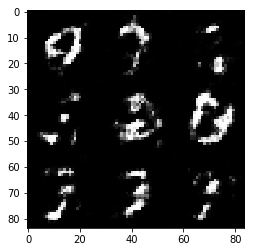

Epoch 1/2..., step 310 Discriminator Loss: 0.7725... Generator Loss: 1.0169
Epoch 1/2..., step 320 Discriminator Loss: 0.9824... Generator Loss: 0.7316
Epoch 1/2..., step 330 Discriminator Loss: 0.6466... Generator Loss: 1.2235
Epoch 1/2..., step 340 Discriminator Loss: 0.6726... Generator Loss: 1.2930
Epoch 1/2..., step 350 Discriminator Loss: 0.6396... Generator Loss: 1.0235
Epoch 1/2..., step 360 Discriminator Loss: 0.8133... Generator Loss: 1.0902
Epoch 1/2..., step 370 Discriminator Loss: 0.8500... Generator Loss: 1.0023
Epoch 1/2..., step 380 Discriminator Loss: 0.5789... Generator Loss: 2.1889
Epoch 1/2..., step 390 Discriminator Loss: 0.6128... Generator Loss: 1.3798
Epoch 1/2..., step 400 Discriminator Loss: 0.6067... Generator Loss: 1.6023


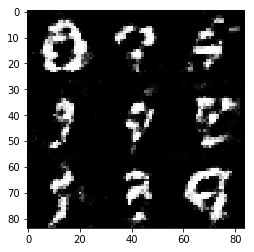

Epoch 1/2..., step 410 Discriminator Loss: 0.8576... Generator Loss: 1.1569
Epoch 1/2..., step 420 Discriminator Loss: 0.7535... Generator Loss: 1.1330
Epoch 1/2..., step 430 Discriminator Loss: 0.9197... Generator Loss: 1.3400
Epoch 1/2..., step 440 Discriminator Loss: 0.6165... Generator Loss: 1.5114
Epoch 1/2..., step 450 Discriminator Loss: 0.8966... Generator Loss: 0.9730
Epoch 1/2..., step 460 Discriminator Loss: 0.9316... Generator Loss: 0.8973
Epoch 1/2..., step 470 Discriminator Loss: 0.9764... Generator Loss: 0.8487
Epoch 1/2..., step 480 Discriminator Loss: 0.9797... Generator Loss: 2.0377
Epoch 1/2..., step 490 Discriminator Loss: 0.9077... Generator Loss: 1.1788
Epoch 1/2..., step 500 Discriminator Loss: 1.3848... Generator Loss: 0.3825


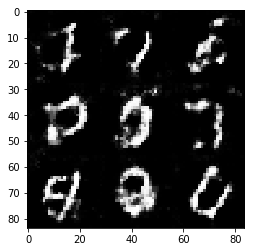

Epoch 1/2..., step 510 Discriminator Loss: 0.8568... Generator Loss: 1.5197
Epoch 1/2..., step 520 Discriminator Loss: 1.2216... Generator Loss: 0.6647
Epoch 1/2..., step 530 Discriminator Loss: 1.0136... Generator Loss: 0.8451
Epoch 1/2..., step 540 Discriminator Loss: 0.7781... Generator Loss: 1.6092
Epoch 1/2..., step 550 Discriminator Loss: 0.8586... Generator Loss: 1.9854
Epoch 1/2..., step 560 Discriminator Loss: 0.9089... Generator Loss: 0.9198
Epoch 1/2..., step 570 Discriminator Loss: 0.9299... Generator Loss: 0.8632
Epoch 1/2..., step 580 Discriminator Loss: 1.1163... Generator Loss: 0.9448
Epoch 1/2..., step 590 Discriminator Loss: 0.9764... Generator Loss: 1.2578
Epoch 1/2..., step 600 Discriminator Loss: 0.7720... Generator Loss: 1.5677


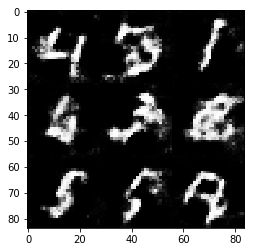

Epoch 1/2..., step 610 Discriminator Loss: 1.0427... Generator Loss: 0.7232
Epoch 1/2..., step 620 Discriminator Loss: 1.1382... Generator Loss: 0.6187
Epoch 1/2..., step 630 Discriminator Loss: 0.9703... Generator Loss: 1.5525
Epoch 1/2..., step 640 Discriminator Loss: 0.7104... Generator Loss: 1.2284
Epoch 1/2..., step 650 Discriminator Loss: 1.3639... Generator Loss: 0.4059
Epoch 1/2..., step 660 Discriminator Loss: 0.8224... Generator Loss: 1.2314
Epoch 1/2..., step 670 Discriminator Loss: 1.2283... Generator Loss: 0.5345
Epoch 1/2..., step 680 Discriminator Loss: 1.0850... Generator Loss: 0.5733
Epoch 1/2..., step 690 Discriminator Loss: 1.2787... Generator Loss: 1.4513
Epoch 1/2..., step 700 Discriminator Loss: 0.8691... Generator Loss: 1.5049


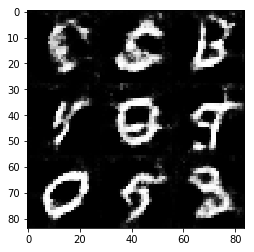

Epoch 1/2..., step 710 Discriminator Loss: 0.9398... Generator Loss: 1.2193
Epoch 1/2..., step 720 Discriminator Loss: 1.1469... Generator Loss: 0.8434
Epoch 1/2..., step 730 Discriminator Loss: 0.9519... Generator Loss: 1.6204
Epoch 1/2..., step 740 Discriminator Loss: 0.9241... Generator Loss: 1.3213
Epoch 1/2..., step 750 Discriminator Loss: 1.1123... Generator Loss: 0.5988
Epoch 1/2..., step 760 Discriminator Loss: 0.8707... Generator Loss: 0.9323
Epoch 1/2..., step 770 Discriminator Loss: 0.9558... Generator Loss: 1.1795
Epoch 1/2..., step 780 Discriminator Loss: 1.1181... Generator Loss: 0.8157
Epoch 1/2..., step 790 Discriminator Loss: 0.9437... Generator Loss: 1.1859
Epoch 1/2..., step 800 Discriminator Loss: 1.0280... Generator Loss: 0.8383


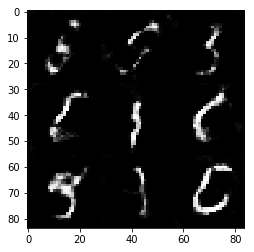

Epoch 1/2..., step 810 Discriminator Loss: 1.1951... Generator Loss: 0.6674
Epoch 1/2..., step 820 Discriminator Loss: 1.2107... Generator Loss: 1.9366
Epoch 1/2..., step 830 Discriminator Loss: 1.2649... Generator Loss: 0.5046
Epoch 1/2..., step 840 Discriminator Loss: 1.3158... Generator Loss: 0.3744
Epoch 1/2..., step 850 Discriminator Loss: 0.8803... Generator Loss: 1.1572
Epoch 1/2..., step 860 Discriminator Loss: 0.7173... Generator Loss: 1.1365
Epoch 1/2..., step 870 Discriminator Loss: 0.8299... Generator Loss: 1.2483
Epoch 1/2..., step 880 Discriminator Loss: 1.1178... Generator Loss: 0.6193
Epoch 1/2..., step 890 Discriminator Loss: 0.7758... Generator Loss: 1.3922
Epoch 1/2..., step 900 Discriminator Loss: 0.8754... Generator Loss: 0.9144


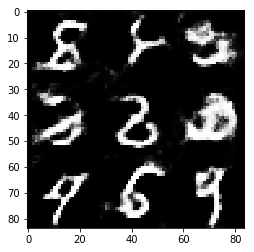

Epoch 1/2..., step 910 Discriminator Loss: 0.9007... Generator Loss: 1.0918
Epoch 1/2..., step 920 Discriminator Loss: 1.1510... Generator Loss: 0.6162
Epoch 1/2..., step 930 Discriminator Loss: 1.1288... Generator Loss: 0.7548
Epoch 1/2..., step 940 Discriminator Loss: 0.9516... Generator Loss: 1.2513
Epoch 1/2..., step 950 Discriminator Loss: 1.1676... Generator Loss: 1.0239
Epoch 1/2..., step 960 Discriminator Loss: 0.7889... Generator Loss: 0.8660
Epoch 1/2..., step 970 Discriminator Loss: 0.7757... Generator Loss: 1.1713
Epoch 1/2..., step 980 Discriminator Loss: 0.8323... Generator Loss: 1.2689
Epoch 1/2..., step 990 Discriminator Loss: 0.8439... Generator Loss: 1.1413
Epoch 1/2..., step 1000 Discriminator Loss: 1.0443... Generator Loss: 1.1727


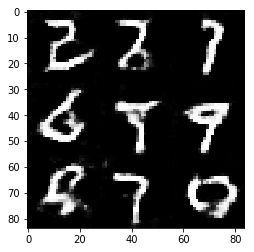

Epoch 1/2..., step 1010 Discriminator Loss: 1.0838... Generator Loss: 0.7452
Epoch 1/2..., step 1020 Discriminator Loss: 0.9277... Generator Loss: 0.7903
Epoch 1/2..., step 1030 Discriminator Loss: 0.8688... Generator Loss: 1.0683
Epoch 1/2..., step 1040 Discriminator Loss: 0.9599... Generator Loss: 0.8355
Epoch 1/2..., step 1050 Discriminator Loss: 1.0774... Generator Loss: 0.9697
Epoch 1/2..., step 1060 Discriminator Loss: 1.0051... Generator Loss: 0.6758
Epoch 1/2..., step 1070 Discriminator Loss: 0.7416... Generator Loss: 1.2513
Epoch 1/2..., step 1080 Discriminator Loss: 0.9114... Generator Loss: 1.1138
Epoch 1/2..., step 1090 Discriminator Loss: 0.8674... Generator Loss: 1.2130
Epoch 1/2..., step 1100 Discriminator Loss: 0.7356... Generator Loss: 1.7091


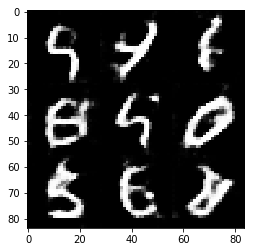

Epoch 1/2..., step 1110 Discriminator Loss: 0.9425... Generator Loss: 1.0608
Epoch 1/2..., step 1120 Discriminator Loss: 1.1520... Generator Loss: 0.6555
Epoch 1/2..., step 1130 Discriminator Loss: 1.1525... Generator Loss: 0.7171
Epoch 1/2..., step 1140 Discriminator Loss: 0.6869... Generator Loss: 1.3856
Epoch 1/2..., step 1150 Discriminator Loss: 0.9318... Generator Loss: 0.8644
Epoch 1/2..., step 1160 Discriminator Loss: 0.8994... Generator Loss: 1.0601
Epoch 1/2..., step 1170 Discriminator Loss: 1.0316... Generator Loss: 0.8713
Epoch 1/2..., step 1180 Discriminator Loss: 1.0748... Generator Loss: 0.8713
Epoch 1/2..., step 1190 Discriminator Loss: 0.8996... Generator Loss: 1.6164
Epoch 1/2..., step 1200 Discriminator Loss: 1.0624... Generator Loss: 1.0453


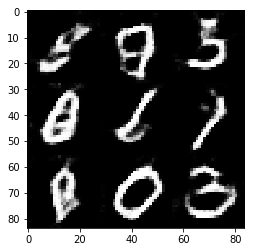

Epoch 1/2..., step 1210 Discriminator Loss: 0.8084... Generator Loss: 0.8556
Epoch 1/2..., step 1220 Discriminator Loss: 1.1624... Generator Loss: 0.6039
Epoch 1/2..., step 1230 Discriminator Loss: 0.8891... Generator Loss: 1.1869
Epoch 1/2..., step 1240 Discriminator Loss: 0.9263... Generator Loss: 1.0779
Epoch 1/2..., step 1250 Discriminator Loss: 1.1503... Generator Loss: 0.6244
Epoch 1/2..., step 1260 Discriminator Loss: 1.0394... Generator Loss: 0.6851
Epoch 1/2..., step 1270 Discriminator Loss: 0.8730... Generator Loss: 1.5146
Epoch 1/2..., step 1280 Discriminator Loss: 0.7245... Generator Loss: 1.4051
Epoch 1/2..., step 1290 Discriminator Loss: 0.6393... Generator Loss: 1.4969
Epoch 1/2..., step 1300 Discriminator Loss: 0.7267... Generator Loss: 1.1308


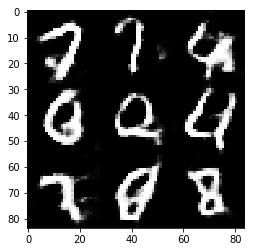

Epoch 1/2..., step 1310 Discriminator Loss: 1.2606... Generator Loss: 1.4921
Epoch 1/2..., step 1320 Discriminator Loss: 0.8785... Generator Loss: 1.0044
Epoch 1/2..., step 1330 Discriminator Loss: 0.9948... Generator Loss: 0.8726
Epoch 1/2..., step 1340 Discriminator Loss: 1.1791... Generator Loss: 1.0577
Epoch 1/2..., step 1350 Discriminator Loss: 1.1305... Generator Loss: 0.5481
Epoch 1/2..., step 1360 Discriminator Loss: 0.9523... Generator Loss: 0.7821
Epoch 1/2..., step 1370 Discriminator Loss: 0.8178... Generator Loss: 1.1268
Epoch 1/2..., step 1380 Discriminator Loss: 0.8649... Generator Loss: 1.0953
Epoch 1/2..., step 1390 Discriminator Loss: 0.8163... Generator Loss: 0.9086
Epoch 1/2..., step 1400 Discriminator Loss: 0.7869... Generator Loss: 1.1409


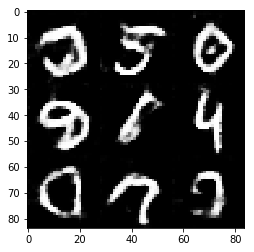

Epoch 1/2..., step 1410 Discriminator Loss: 0.9526... Generator Loss: 0.8610
Epoch 1/2..., step 1420 Discriminator Loss: 0.8776... Generator Loss: 0.8685
Epoch 1/2..., step 1430 Discriminator Loss: 0.8182... Generator Loss: 1.5437
Epoch 1/2..., step 1440 Discriminator Loss: 0.9891... Generator Loss: 0.6502
Epoch 1/2..., step 1450 Discriminator Loss: 0.9059... Generator Loss: 1.1526
Epoch 1/2..., step 1460 Discriminator Loss: 0.7672... Generator Loss: 1.1902
Epoch 1/2..., step 1470 Discriminator Loss: 0.9117... Generator Loss: 2.0760
Epoch 1/2..., step 1480 Discriminator Loss: 0.8309... Generator Loss: 1.6493
Epoch 1/2..., step 1490 Discriminator Loss: 0.9793... Generator Loss: 1.1042
Epoch 1/2..., step 1500 Discriminator Loss: 1.0568... Generator Loss: 0.6753


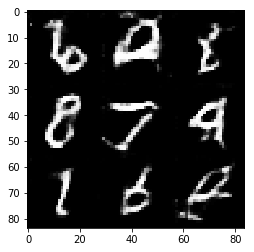

Epoch 1/2..., step 1510 Discriminator Loss: 0.9917... Generator Loss: 0.8715
Epoch 1/2..., step 1520 Discriminator Loss: 0.8313... Generator Loss: 1.2949
Epoch 1/2..., step 1530 Discriminator Loss: 0.8569... Generator Loss: 0.7532
Epoch 1/2..., step 1540 Discriminator Loss: 0.8700... Generator Loss: 1.1893
Epoch 1/2..., step 1550 Discriminator Loss: 0.9476... Generator Loss: 1.0767
Epoch 1/2..., step 1560 Discriminator Loss: 0.8520... Generator Loss: 1.1152
Epoch 1/2..., step 1570 Discriminator Loss: 1.0032... Generator Loss: 0.8239
Epoch 1/2..., step 1580 Discriminator Loss: 0.8953... Generator Loss: 0.9214
Epoch 1/2..., step 1590 Discriminator Loss: 1.1123... Generator Loss: 0.7733
Epoch 1/2..., step 1600 Discriminator Loss: 1.0268... Generator Loss: 1.6749


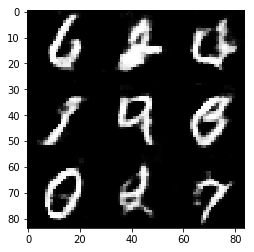

Epoch 1/2..., step 1610 Discriminator Loss: 0.8839... Generator Loss: 0.8631
Epoch 1/2..., step 1620 Discriminator Loss: 1.0346... Generator Loss: 0.6793
Epoch 1/2..., step 1630 Discriminator Loss: 0.9272... Generator Loss: 0.8578
Epoch 1/2..., step 1640 Discriminator Loss: 0.8970... Generator Loss: 0.7707
Epoch 1/2..., step 1650 Discriminator Loss: 1.5148... Generator Loss: 0.4111
Epoch 1/2..., step 1660 Discriminator Loss: 0.9227... Generator Loss: 1.1387
Epoch 1/2..., step 1670 Discriminator Loss: 1.0459... Generator Loss: 0.8152
Epoch 1/2..., step 1680 Discriminator Loss: 0.8633... Generator Loss: 1.1456
Epoch 1/2..., step 1690 Discriminator Loss: 0.9167... Generator Loss: 1.0051
Epoch 1/2..., step 1700 Discriminator Loss: 0.8263... Generator Loss: 0.9987


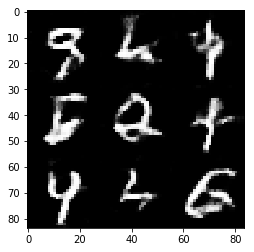

Epoch 1/2..., step 1710 Discriminator Loss: 0.8727... Generator Loss: 1.0022
Epoch 1/2..., step 1720 Discriminator Loss: 1.2078... Generator Loss: 0.5468
Epoch 1/2..., step 1730 Discriminator Loss: 0.8935... Generator Loss: 0.8211
Epoch 1/2..., step 1740 Discriminator Loss: 0.7371... Generator Loss: 1.7359
Epoch 1/2..., step 1750 Discriminator Loss: 0.9946... Generator Loss: 0.8281
Epoch 1/2..., step 1760 Discriminator Loss: 0.7990... Generator Loss: 1.2371
Epoch 1/2..., step 1770 Discriminator Loss: 0.8078... Generator Loss: 1.1325
Epoch 1/2..., step 1780 Discriminator Loss: 0.8072... Generator Loss: 1.2030
Epoch 1/2..., step 1790 Discriminator Loss: 0.7781... Generator Loss: 1.2459
Epoch 1/2..., step 1800 Discriminator Loss: 0.7418... Generator Loss: 1.2951


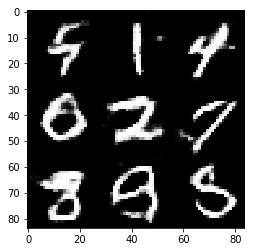

Epoch 1/2..., step 1810 Discriminator Loss: 0.7601... Generator Loss: 1.0898
Epoch 1/2..., step 1820 Discriminator Loss: 1.1761... Generator Loss: 0.5424
Epoch 1/2..., step 1830 Discriminator Loss: 0.9644... Generator Loss: 0.9406
Epoch 1/2..., step 1840 Discriminator Loss: 0.7805... Generator Loss: 1.2821
Epoch 1/2..., step 1850 Discriminator Loss: 0.9843... Generator Loss: 0.7731
Epoch 1/2..., step 1860 Discriminator Loss: 0.9769... Generator Loss: 0.9513
Epoch 1/2..., step 1870 Discriminator Loss: 0.9782... Generator Loss: 1.4990
Epoch 2/2..., step 1880 Discriminator Loss: 1.0824... Generator Loss: 0.7159
Epoch 2/2..., step 1890 Discriminator Loss: 0.8644... Generator Loss: 1.4770
Epoch 2/2..., step 1900 Discriminator Loss: 1.1248... Generator Loss: 0.6491


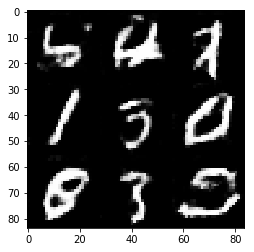

Epoch 2/2..., step 1910 Discriminator Loss: 0.9830... Generator Loss: 1.1250
Epoch 2/2..., step 1920 Discriminator Loss: 0.8842... Generator Loss: 1.1262
Epoch 2/2..., step 1930 Discriminator Loss: 0.8876... Generator Loss: 1.0299
Epoch 2/2..., step 1940 Discriminator Loss: 0.9372... Generator Loss: 0.8300
Epoch 2/2..., step 1950 Discriminator Loss: 1.1125... Generator Loss: 0.8327
Epoch 2/2..., step 1960 Discriminator Loss: 0.8313... Generator Loss: 0.9313
Epoch 2/2..., step 1970 Discriminator Loss: 0.9671... Generator Loss: 0.8141
Epoch 2/2..., step 1980 Discriminator Loss: 0.7548... Generator Loss: 1.1309
Epoch 2/2..., step 1990 Discriminator Loss: 0.6827... Generator Loss: 1.7665
Epoch 2/2..., step 2000 Discriminator Loss: 0.8747... Generator Loss: 1.0407


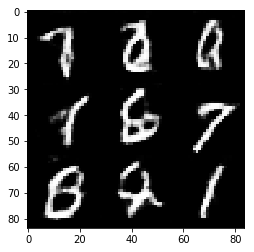

Epoch 2/2..., step 2010 Discriminator Loss: 0.7614... Generator Loss: 1.8097
Epoch 2/2..., step 2020 Discriminator Loss: 0.8921... Generator Loss: 0.9404
Epoch 2/2..., step 2030 Discriminator Loss: 0.8915... Generator Loss: 1.3276
Epoch 2/2..., step 2040 Discriminator Loss: 0.7378... Generator Loss: 1.4292
Epoch 2/2..., step 2050 Discriminator Loss: 1.0363... Generator Loss: 0.6788
Epoch 2/2..., step 2060 Discriminator Loss: 0.7356... Generator Loss: 0.9353
Epoch 2/2..., step 2070 Discriminator Loss: 1.0674... Generator Loss: 0.6134
Epoch 2/2..., step 2080 Discriminator Loss: 0.8340... Generator Loss: 1.0657
Epoch 2/2..., step 2090 Discriminator Loss: 0.9471... Generator Loss: 0.7628
Epoch 2/2..., step 2100 Discriminator Loss: 1.1549... Generator Loss: 0.6148


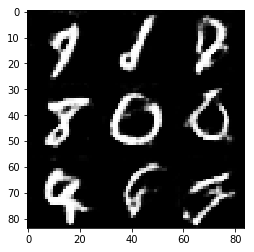

Epoch 2/2..., step 2110 Discriminator Loss: 0.7155... Generator Loss: 1.1166
Epoch 2/2..., step 2120 Discriminator Loss: 0.9491... Generator Loss: 1.2293
Epoch 2/2..., step 2130 Discriminator Loss: 0.9748... Generator Loss: 0.8437
Epoch 2/2..., step 2140 Discriminator Loss: 0.7795... Generator Loss: 0.8643
Epoch 2/2..., step 2150 Discriminator Loss: 0.9473... Generator Loss: 0.7065
Epoch 2/2..., step 2160 Discriminator Loss: 1.0331... Generator Loss: 0.8377
Epoch 2/2..., step 2170 Discriminator Loss: 0.8988... Generator Loss: 1.3727
Epoch 2/2..., step 2180 Discriminator Loss: 1.1685... Generator Loss: 0.5754
Epoch 2/2..., step 2190 Discriminator Loss: 0.7901... Generator Loss: 0.9646
Epoch 2/2..., step 2200 Discriminator Loss: 0.6793... Generator Loss: 1.1791


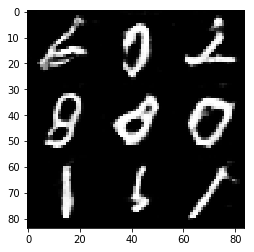

Epoch 2/2..., step 2210 Discriminator Loss: 0.8738... Generator Loss: 0.7134
Epoch 2/2..., step 2220 Discriminator Loss: 1.0798... Generator Loss: 0.7160
Epoch 2/2..., step 2230 Discriminator Loss: 0.9323... Generator Loss: 0.9487
Epoch 2/2..., step 2240 Discriminator Loss: 0.9513... Generator Loss: 0.6750
Epoch 2/2..., step 2250 Discriminator Loss: 0.8692... Generator Loss: 1.2709
Epoch 2/2..., step 2260 Discriminator Loss: 1.1605... Generator Loss: 0.5048
Epoch 2/2..., step 2270 Discriminator Loss: 0.9716... Generator Loss: 1.0925
Epoch 2/2..., step 2280 Discriminator Loss: 0.8533... Generator Loss: 1.7383
Epoch 2/2..., step 2290 Discriminator Loss: 0.8631... Generator Loss: 0.9280
Epoch 2/2..., step 2300 Discriminator Loss: 1.2143... Generator Loss: 0.4797


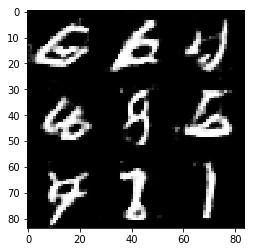

Epoch 2/2..., step 2310 Discriminator Loss: 0.7737... Generator Loss: 0.9863
Epoch 2/2..., step 2320 Discriminator Loss: 0.7899... Generator Loss: 1.0420
Epoch 2/2..., step 2330 Discriminator Loss: 0.9135... Generator Loss: 1.5084
Epoch 2/2..., step 2340 Discriminator Loss: 0.8394... Generator Loss: 0.9233
Epoch 2/2..., step 2350 Discriminator Loss: 0.7831... Generator Loss: 1.2787
Epoch 2/2..., step 2360 Discriminator Loss: 0.6153... Generator Loss: 1.5976
Epoch 2/2..., step 2370 Discriminator Loss: 1.1116... Generator Loss: 0.6325
Epoch 2/2..., step 2380 Discriminator Loss: 0.6801... Generator Loss: 1.6486
Epoch 2/2..., step 2390 Discriminator Loss: 0.8149... Generator Loss: 1.1602
Epoch 2/2..., step 2400 Discriminator Loss: 0.8846... Generator Loss: 1.1408


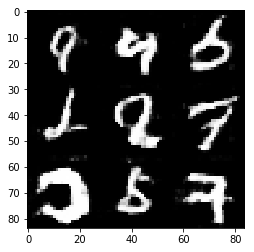

Epoch 2/2..., step 2410 Discriminator Loss: 0.8907... Generator Loss: 0.9515
Epoch 2/2..., step 2420 Discriminator Loss: 1.2052... Generator Loss: 0.5652
Epoch 2/2..., step 2430 Discriminator Loss: 0.5350... Generator Loss: 1.2044
Epoch 2/2..., step 2440 Discriminator Loss: 0.7980... Generator Loss: 1.1375
Epoch 2/2..., step 2450 Discriminator Loss: 0.8723... Generator Loss: 0.9291
Epoch 2/2..., step 2460 Discriminator Loss: 1.0755... Generator Loss: 0.7204
Epoch 2/2..., step 2470 Discriminator Loss: 0.9473... Generator Loss: 1.1501
Epoch 2/2..., step 2480 Discriminator Loss: 0.6138... Generator Loss: 1.5698
Epoch 2/2..., step 2490 Discriminator Loss: 0.7751... Generator Loss: 0.8206
Epoch 2/2..., step 2500 Discriminator Loss: 0.9311... Generator Loss: 1.2866


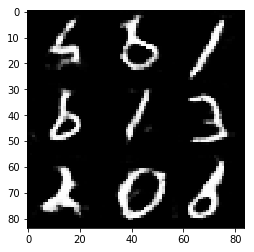

Epoch 2/2..., step 2510 Discriminator Loss: 0.8893... Generator Loss: 0.8003
Epoch 2/2..., step 2520 Discriminator Loss: 0.8162... Generator Loss: 1.1040
Epoch 2/2..., step 2530 Discriminator Loss: 0.6954... Generator Loss: 1.3058
Epoch 2/2..., step 2540 Discriminator Loss: 0.9187... Generator Loss: 1.0544
Epoch 2/2..., step 2550 Discriminator Loss: 0.8774... Generator Loss: 0.8091
Epoch 2/2..., step 2560 Discriminator Loss: 1.2307... Generator Loss: 0.5046
Epoch 2/2..., step 2570 Discriminator Loss: 0.8041... Generator Loss: 0.7938
Epoch 2/2..., step 2580 Discriminator Loss: 0.9216... Generator Loss: 1.2141
Epoch 2/2..., step 2590 Discriminator Loss: 0.7680... Generator Loss: 1.6073
Epoch 2/2..., step 2600 Discriminator Loss: 0.7850... Generator Loss: 1.1301


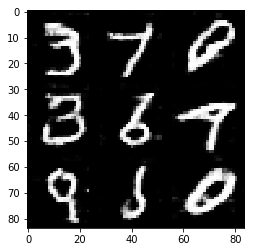

Epoch 2/2..., step 2610 Discriminator Loss: 0.6113... Generator Loss: 1.3115
Epoch 2/2..., step 2620 Discriminator Loss: 0.7322... Generator Loss: 1.2190
Epoch 2/2..., step 2630 Discriminator Loss: 0.9990... Generator Loss: 1.6750
Epoch 2/2..., step 2640 Discriminator Loss: 1.1697... Generator Loss: 0.5017
Epoch 2/2..., step 2650 Discriminator Loss: 1.1489... Generator Loss: 0.6166
Epoch 2/2..., step 2660 Discriminator Loss: 0.8044... Generator Loss: 0.9107
Epoch 2/2..., step 2670 Discriminator Loss: 0.9310... Generator Loss: 0.7310
Epoch 2/2..., step 2680 Discriminator Loss: 0.6065... Generator Loss: 1.1758
Epoch 2/2..., step 2690 Discriminator Loss: 0.5985... Generator Loss: 1.3892
Epoch 2/2..., step 2700 Discriminator Loss: 0.6241... Generator Loss: 1.3593


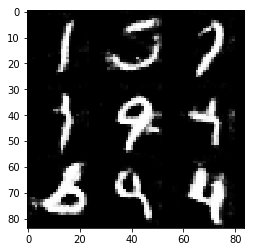

Epoch 2/2..., step 2710 Discriminator Loss: 0.8357... Generator Loss: 1.1309
Epoch 2/2..., step 2720 Discriminator Loss: 1.2563... Generator Loss: 0.5183
Epoch 2/2..., step 2730 Discriminator Loss: 0.8940... Generator Loss: 1.4221
Epoch 2/2..., step 2740 Discriminator Loss: 0.8982... Generator Loss: 1.1407
Epoch 2/2..., step 2750 Discriminator Loss: 0.8063... Generator Loss: 1.0870
Epoch 2/2..., step 2760 Discriminator Loss: 1.0025... Generator Loss: 0.9288
Epoch 2/2..., step 2770 Discriminator Loss: 0.8064... Generator Loss: 1.2704
Epoch 2/2..., step 2780 Discriminator Loss: 0.6990... Generator Loss: 1.6818
Epoch 2/2..., step 2790 Discriminator Loss: 0.6159... Generator Loss: 1.1894
Epoch 2/2..., step 2800 Discriminator Loss: 1.0477... Generator Loss: 0.6836


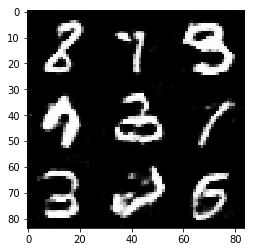

Epoch 2/2..., step 2810 Discriminator Loss: 0.9070... Generator Loss: 0.8712
Epoch 2/2..., step 2820 Discriminator Loss: 1.4955... Generator Loss: 0.4348
Epoch 2/2..., step 2830 Discriminator Loss: 0.7170... Generator Loss: 0.9870
Epoch 2/2..., step 2840 Discriminator Loss: 1.0817... Generator Loss: 0.4892
Epoch 2/2..., step 2850 Discriminator Loss: 0.9471... Generator Loss: 0.7094
Epoch 2/2..., step 2860 Discriminator Loss: 0.9262... Generator Loss: 0.7345
Epoch 2/2..., step 2870 Discriminator Loss: 0.7631... Generator Loss: 1.0974
Epoch 2/2..., step 2880 Discriminator Loss: 1.3033... Generator Loss: 0.4825
Epoch 2/2..., step 2890 Discriminator Loss: 0.6323... Generator Loss: 1.2260
Epoch 2/2..., step 2900 Discriminator Loss: 0.8786... Generator Loss: 1.6639


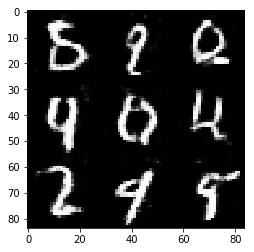

Epoch 2/2..., step 2910 Discriminator Loss: 1.2543... Generator Loss: 0.4813
Epoch 2/2..., step 2920 Discriminator Loss: 0.8310... Generator Loss: 1.5219
Epoch 2/2..., step 2930 Discriminator Loss: 0.6094... Generator Loss: 1.5530
Epoch 2/2..., step 2940 Discriminator Loss: 0.9493... Generator Loss: 1.1291
Epoch 2/2..., step 2950 Discriminator Loss: 0.6653... Generator Loss: 1.0980
Epoch 2/2..., step 2960 Discriminator Loss: 0.7571... Generator Loss: 1.1573
Epoch 2/2..., step 2970 Discriminator Loss: 0.8230... Generator Loss: 0.9985
Epoch 2/2..., step 2980 Discriminator Loss: 0.9229... Generator Loss: 1.0812
Epoch 2/2..., step 2990 Discriminator Loss: 0.8070... Generator Loss: 1.1527
Epoch 2/2..., step 3000 Discriminator Loss: 0.9783... Generator Loss: 0.7714


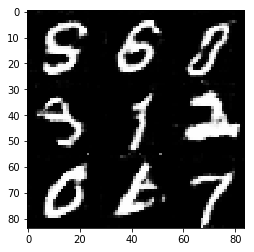

Epoch 2/2..., step 3010 Discriminator Loss: 0.7564... Generator Loss: 1.0878
Epoch 2/2..., step 3020 Discriminator Loss: 0.6039... Generator Loss: 1.7365
Epoch 2/2..., step 3030 Discriminator Loss: 0.7076... Generator Loss: 1.0784
Epoch 2/2..., step 3040 Discriminator Loss: 0.8589... Generator Loss: 0.8325
Epoch 2/2..., step 3050 Discriminator Loss: 0.8472... Generator Loss: 0.6850
Epoch 2/2..., step 3060 Discriminator Loss: 0.9174... Generator Loss: 0.9332
Epoch 2/2..., step 3070 Discriminator Loss: 0.5831... Generator Loss: 1.3039
Epoch 2/2..., step 3080 Discriminator Loss: 0.7318... Generator Loss: 1.5007
Epoch 2/2..., step 3090 Discriminator Loss: 0.6963... Generator Loss: 1.6318
Epoch 2/2..., step 3100 Discriminator Loss: 0.7566... Generator Loss: 1.3486


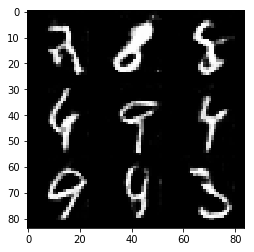

Epoch 2/2..., step 3110 Discriminator Loss: 1.2524... Generator Loss: 0.5372
Epoch 2/2..., step 3120 Discriminator Loss: 0.9479... Generator Loss: 1.0082
Epoch 2/2..., step 3130 Discriminator Loss: 0.7083... Generator Loss: 1.6010
Epoch 2/2..., step 3140 Discriminator Loss: 0.9033... Generator Loss: 0.8645
Epoch 2/2..., step 3150 Discriminator Loss: 0.9996... Generator Loss: 0.7113
Epoch 2/2..., step 3160 Discriminator Loss: 0.5343... Generator Loss: 1.4957
Epoch 2/2..., step 3170 Discriminator Loss: 0.7616... Generator Loss: 1.0377
Epoch 2/2..., step 3180 Discriminator Loss: 0.7560... Generator Loss: 1.6214
Epoch 2/2..., step 3190 Discriminator Loss: 0.7373... Generator Loss: 1.1226
Epoch 2/2..., step 3200 Discriminator Loss: 0.9402... Generator Loss: 0.6681


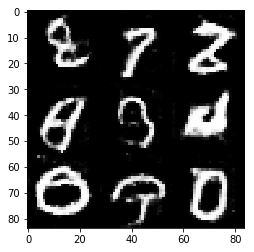

Epoch 2/2..., step 3210 Discriminator Loss: 0.6681... Generator Loss: 1.2554
Epoch 2/2..., step 3220 Discriminator Loss: 0.8907... Generator Loss: 0.7981
Epoch 2/2..., step 3230 Discriminator Loss: 0.8940... Generator Loss: 1.6372
Epoch 2/2..., step 3240 Discriminator Loss: 0.8310... Generator Loss: 0.6391
Epoch 2/2..., step 3250 Discriminator Loss: 0.5900... Generator Loss: 1.2320
Epoch 2/2..., step 3260 Discriminator Loss: 0.6539... Generator Loss: 1.4572
Epoch 2/2..., step 3270 Discriminator Loss: 0.6447... Generator Loss: 2.0396
Epoch 2/2..., step 3280 Discriminator Loss: 0.6546... Generator Loss: 1.2157
Epoch 2/2..., step 3290 Discriminator Loss: 0.7940... Generator Loss: 1.5482
Epoch 2/2..., step 3300 Discriminator Loss: 0.7310... Generator Loss: 1.2450


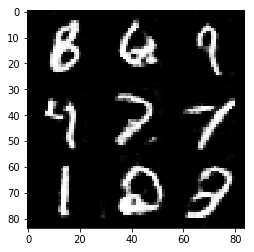

Epoch 2/2..., step 3310 Discriminator Loss: 0.6985... Generator Loss: 1.6071
Epoch 2/2..., step 3320 Discriminator Loss: 0.8546... Generator Loss: 0.8919
Epoch 2/2..., step 3330 Discriminator Loss: 0.8138... Generator Loss: 0.8538
Epoch 2/2..., step 3340 Discriminator Loss: 0.7888... Generator Loss: 1.2321
Epoch 2/2..., step 3350 Discriminator Loss: 0.6209... Generator Loss: 1.4132
Epoch 2/2..., step 3360 Discriminator Loss: 1.3136... Generator Loss: 0.4236
Epoch 2/2..., step 3370 Discriminator Loss: 0.6780... Generator Loss: 1.5093
Epoch 2/2..., step 3380 Discriminator Loss: 0.6368... Generator Loss: 1.3593
Epoch 2/2..., step 3390 Discriminator Loss: 0.8658... Generator Loss: 1.3718
Epoch 2/2..., step 3400 Discriminator Loss: 0.4790... Generator Loss: 1.4411


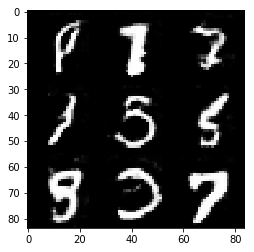

Epoch 2/2..., step 3410 Discriminator Loss: 0.6908... Generator Loss: 0.8308
Epoch 2/2..., step 3420 Discriminator Loss: 0.9595... Generator Loss: 0.7743
Epoch 2/2..., step 3430 Discriminator Loss: 0.6645... Generator Loss: 1.0787
Epoch 2/2..., step 3440 Discriminator Loss: 0.7248... Generator Loss: 0.8338
Epoch 2/2..., step 3450 Discriminator Loss: 0.8183... Generator Loss: 0.9101
Epoch 2/2..., step 3460 Discriminator Loss: 0.7340... Generator Loss: 1.1012
Epoch 2/2..., step 3470 Discriminator Loss: 0.7860... Generator Loss: 1.8896
Epoch 2/2..., step 3480 Discriminator Loss: 0.7463... Generator Loss: 1.4344
Epoch 2/2..., step 3490 Discriminator Loss: 0.6327... Generator Loss: 1.5216
Epoch 2/2..., step 3500 Discriminator Loss: 0.7012... Generator Loss: 1.4204


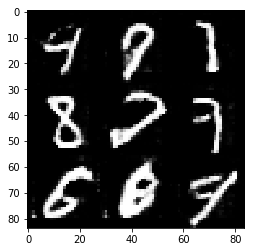

Epoch 2/2..., step 3510 Discriminator Loss: 0.9098... Generator Loss: 0.9667
Epoch 2/2..., step 3520 Discriminator Loss: 0.6991... Generator Loss: 1.1569
Epoch 2/2..., step 3530 Discriminator Loss: 0.3824... Generator Loss: 1.8448
Epoch 2/2..., step 3540 Discriminator Loss: 0.9775... Generator Loss: 0.7111
Epoch 2/2..., step 3550 Discriminator Loss: 0.7424... Generator Loss: 1.2506
Epoch 2/2..., step 3560 Discriminator Loss: 0.9314... Generator Loss: 0.7266
Epoch 2/2..., step 3570 Discriminator Loss: 0.9930... Generator Loss: 0.6520
Epoch 2/2..., step 3580 Discriminator Loss: 0.5430... Generator Loss: 1.3257
Epoch 2/2..., step 3590 Discriminator Loss: 1.1006... Generator Loss: 0.7032
Epoch 2/2..., step 3600 Discriminator Loss: 0.5722... Generator Loss: 2.2382


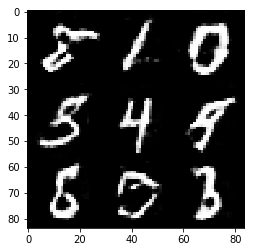

Epoch 2/2..., step 3610 Discriminator Loss: 0.7823... Generator Loss: 0.9839
Epoch 2/2..., step 3620 Discriminator Loss: 1.0124... Generator Loss: 0.6770
Epoch 2/2..., step 3630 Discriminator Loss: 0.7415... Generator Loss: 1.0511
Epoch 2/2..., step 3640 Discriminator Loss: 0.7210... Generator Loss: 1.0906
Epoch 2/2..., step 3650 Discriminator Loss: 0.5211... Generator Loss: 1.7741
Epoch 2/2..., step 3660 Discriminator Loss: 0.7698... Generator Loss: 1.8215
Epoch 2/2..., step 3670 Discriminator Loss: 1.3106... Generator Loss: 0.6070
Epoch 2/2..., step 3680 Discriminator Loss: 0.7997... Generator Loss: 1.2493
Epoch 2/2..., step 3690 Discriminator Loss: 1.0862... Generator Loss: 0.5952
Epoch 2/2..., step 3700 Discriminator Loss: 0.5486... Generator Loss: 1.4682


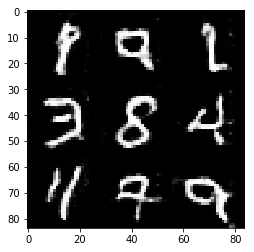

Epoch 2/2..., step 3710 Discriminator Loss: 0.5340... Generator Loss: 1.4626
Epoch 2/2..., step 3720 Discriminator Loss: 0.4577... Generator Loss: 1.5160
Epoch 2/2..., step 3730 Discriminator Loss: 0.6639... Generator Loss: 1.5646
Epoch 2/2..., step 3740 Discriminator Loss: 0.6001... Generator Loss: 1.8356
Epoch 2/2..., step 3750 Discriminator Loss: 0.4978... Generator Loss: 1.7569


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1..., step 10 Discriminator Loss: 0.0085... Generator Loss: 5.3927
Epoch 1/1..., step 20 Discriminator Loss: 8.4042... Generator Loss: 26.8079
Epoch 1/1..., step 30 Discriminator Loss: 0.3520... Generator Loss: 16.9862
Epoch 1/1..., step 40 Discriminator Loss: 0.1404... Generator Loss: 12.9042
Epoch 1/1..., step 50 Discriminator Loss: 0.0316... Generator Loss: 4.2502
Epoch 1/1..., step 60 Discriminator Loss: 0.0077... Generator Loss: 6.0482
Epoch 1/1..., step 70 Discriminator Loss: 0.0079... Generator Loss: 6.2635
Epoch 1/1..., step 80 Discriminator Loss: 0.0022... Generator Loss: 7.0128
Epoch 1/1..., step 90 Discriminator Loss: 0.0140... Generator Loss: 24.8445
Epoch 1/1..., step 100 Discriminator Loss: 0.0009... Generator Loss: 18.9034


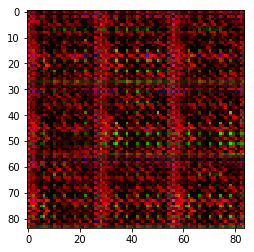

Epoch 1/1..., step 110 Discriminator Loss: 0.0007... Generator Loss: 14.3877
Epoch 1/1..., step 120 Discriminator Loss: 0.0057... Generator Loss: 5.8562
Epoch 1/1..., step 130 Discriminator Loss: 0.0085... Generator Loss: 10.0195
Epoch 1/1..., step 140 Discriminator Loss: 0.0064... Generator Loss: 5.2969
Epoch 1/1..., step 150 Discriminator Loss: 0.0065... Generator Loss: 5.3656
Epoch 1/1..., step 160 Discriminator Loss: 0.0074... Generator Loss: 6.5079
Epoch 1/1..., step 170 Discriminator Loss: 0.0022... Generator Loss: 7.1547
Epoch 1/1..., step 180 Discriminator Loss: 10.9348... Generator Loss: 0.0000
Epoch 1/1..., step 190 Discriminator Loss: 0.0997... Generator Loss: 10.4347
Epoch 1/1..., step 200 Discriminator Loss: 0.0634... Generator Loss: 3.3699


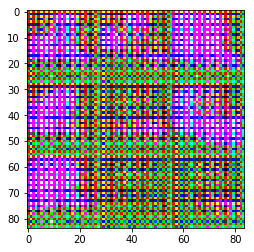

Epoch 1/1..., step 210 Discriminator Loss: 0.1523... Generator Loss: 8.5285
Epoch 1/1..., step 220 Discriminator Loss: 0.1824... Generator Loss: 3.2868
Epoch 1/1..., step 230 Discriminator Loss: 0.4495... Generator Loss: 1.7869
Epoch 1/1..., step 240 Discriminator Loss: 0.5372... Generator Loss: 3.2621
Epoch 1/1..., step 250 Discriminator Loss: 0.0842... Generator Loss: 3.6073
Epoch 1/1..., step 260 Discriminator Loss: 0.1866... Generator Loss: 2.4754
Epoch 1/1..., step 270 Discriminator Loss: 0.4530... Generator Loss: 1.4910
Epoch 1/1..., step 280 Discriminator Loss: 0.2678... Generator Loss: 2.1387
Epoch 1/1..., step 290 Discriminator Loss: 0.0405... Generator Loss: 3.7151
Epoch 1/1..., step 300 Discriminator Loss: 0.0451... Generator Loss: 3.6380


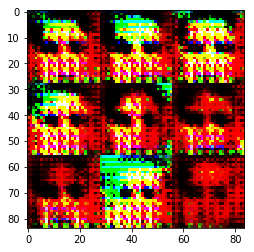

Epoch 1/1..., step 310 Discriminator Loss: 0.0314... Generator Loss: 4.2210
Epoch 1/1..., step 320 Discriminator Loss: 0.0109... Generator Loss: 5.2791
Epoch 1/1..., step 330 Discriminator Loss: 0.0323... Generator Loss: 3.9970
Epoch 1/1..., step 340 Discriminator Loss: 0.0735... Generator Loss: 3.3581
Epoch 1/1..., step 350 Discriminator Loss: 0.3437... Generator Loss: 4.7387
Epoch 1/1..., step 360 Discriminator Loss: 3.9395... Generator Loss: 8.7490
Epoch 1/1..., step 370 Discriminator Loss: 2.3421... Generator Loss: 5.1766
Epoch 1/1..., step 380 Discriminator Loss: 1.4822... Generator Loss: 4.9628
Epoch 1/1..., step 390 Discriminator Loss: 1.1471... Generator Loss: 0.7990
Epoch 1/1..., step 400 Discriminator Loss: 0.9837... Generator Loss: 0.8993


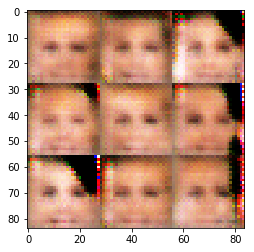

Epoch 1/1..., step 410 Discriminator Loss: 2.0390... Generator Loss: 3.5675
Epoch 1/1..., step 420 Discriminator Loss: 1.5364... Generator Loss: 0.3947
Epoch 1/1..., step 430 Discriminator Loss: 1.1939... Generator Loss: 1.2887
Epoch 1/1..., step 440 Discriminator Loss: 1.5419... Generator Loss: 1.2662
Epoch 1/1..., step 450 Discriminator Loss: 1.8036... Generator Loss: 3.2415
Epoch 1/1..., step 460 Discriminator Loss: 3.1937... Generator Loss: 4.3472
Epoch 1/1..., step 470 Discriminator Loss: 1.0235... Generator Loss: 1.0246
Epoch 1/1..., step 480 Discriminator Loss: 1.4584... Generator Loss: 0.5755
Epoch 1/1..., step 490 Discriminator Loss: 1.1131... Generator Loss: 0.7466
Epoch 1/1..., step 500 Discriminator Loss: 0.9531... Generator Loss: 0.7970


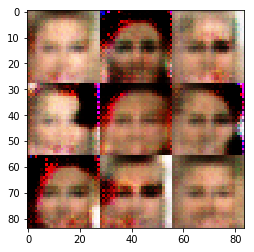

Epoch 1/1..., step 510 Discriminator Loss: 0.7088... Generator Loss: 1.1575
Epoch 1/1..., step 520 Discriminator Loss: 2.1747... Generator Loss: 0.1610
Epoch 1/1..., step 530 Discriminator Loss: 1.8533... Generator Loss: 2.6703
Epoch 1/1..., step 540 Discriminator Loss: 1.4204... Generator Loss: 0.3686
Epoch 1/1..., step 550 Discriminator Loss: 1.0811... Generator Loss: 0.5818
Epoch 1/1..., step 560 Discriminator Loss: 0.9638... Generator Loss: 3.8446
Epoch 1/1..., step 570 Discriminator Loss: 1.0797... Generator Loss: 0.6607
Epoch 1/1..., step 580 Discriminator Loss: 0.9444... Generator Loss: 2.3490
Epoch 1/1..., step 590 Discriminator Loss: 1.6190... Generator Loss: 0.2804
Epoch 1/1..., step 600 Discriminator Loss: 0.3409... Generator Loss: 1.8048


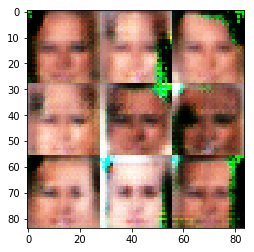

Epoch 1/1..., step 610 Discriminator Loss: 1.3772... Generator Loss: 1.0296
Epoch 1/1..., step 620 Discriminator Loss: 0.9491... Generator Loss: 1.0967
Epoch 1/1..., step 630 Discriminator Loss: 1.4172... Generator Loss: 0.3669
Epoch 1/1..., step 640 Discriminator Loss: 2.1133... Generator Loss: 0.1940
Epoch 1/1..., step 650 Discriminator Loss: 1.0625... Generator Loss: 1.0716
Epoch 1/1..., step 660 Discriminator Loss: 0.7582... Generator Loss: 0.9240
Epoch 1/1..., step 670 Discriminator Loss: 1.8626... Generator Loss: 0.2346
Epoch 1/1..., step 680 Discriminator Loss: 3.4163... Generator Loss: 0.0450
Epoch 1/1..., step 690 Discriminator Loss: 1.5852... Generator Loss: 0.4270
Epoch 1/1..., step 700 Discriminator Loss: 1.1512... Generator Loss: 1.4694


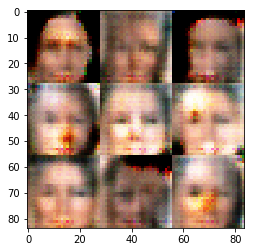

Epoch 1/1..., step 710 Discriminator Loss: 1.4360... Generator Loss: 2.3442
Epoch 1/1..., step 720 Discriminator Loss: 1.7252... Generator Loss: 0.2576
Epoch 1/1..., step 730 Discriminator Loss: 0.9773... Generator Loss: 1.0826
Epoch 1/1..., step 740 Discriminator Loss: 1.1919... Generator Loss: 1.4941
Epoch 1/1..., step 750 Discriminator Loss: 1.2942... Generator Loss: 2.1040
Epoch 1/1..., step 760 Discriminator Loss: 1.0052... Generator Loss: 1.3919
Epoch 1/1..., step 770 Discriminator Loss: 1.8078... Generator Loss: 2.8020
Epoch 1/1..., step 780 Discriminator Loss: 1.3681... Generator Loss: 0.3926
Epoch 1/1..., step 790 Discriminator Loss: 1.6741... Generator Loss: 2.5101
Epoch 1/1..., step 800 Discriminator Loss: 1.0100... Generator Loss: 0.7240


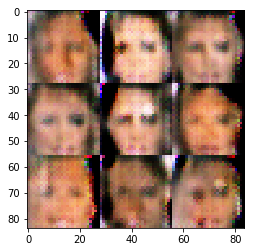

Epoch 1/1..., step 810 Discriminator Loss: 2.2501... Generator Loss: 0.1348
Epoch 1/1..., step 820 Discriminator Loss: 1.0009... Generator Loss: 0.8941
Epoch 1/1..., step 830 Discriminator Loss: 1.6482... Generator Loss: 0.4883
Epoch 1/1..., step 840 Discriminator Loss: 1.6096... Generator Loss: 0.2863
Epoch 1/1..., step 850 Discriminator Loss: 0.9148... Generator Loss: 0.9362
Epoch 1/1..., step 860 Discriminator Loss: 1.0472... Generator Loss: 0.7560
Epoch 1/1..., step 870 Discriminator Loss: 1.3342... Generator Loss: 0.4122
Epoch 1/1..., step 880 Discriminator Loss: 1.3328... Generator Loss: 1.5018
Epoch 1/1..., step 890 Discriminator Loss: 0.9379... Generator Loss: 1.4000
Epoch 1/1..., step 900 Discriminator Loss: 1.4941... Generator Loss: 0.3745


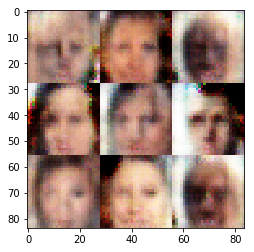

Epoch 1/1..., step 910 Discriminator Loss: 1.7773... Generator Loss: 1.8469
Epoch 1/1..., step 920 Discriminator Loss: 0.9952... Generator Loss: 0.9807
Epoch 1/1..., step 930 Discriminator Loss: 1.5534... Generator Loss: 1.8055
Epoch 1/1..., step 940 Discriminator Loss: 0.8983... Generator Loss: 0.9418
Epoch 1/1..., step 950 Discriminator Loss: 1.0511... Generator Loss: 1.1188
Epoch 1/1..., step 960 Discriminator Loss: 1.0454... Generator Loss: 0.6239
Epoch 1/1..., step 970 Discriminator Loss: 1.7039... Generator Loss: 0.2513
Epoch 1/1..., step 980 Discriminator Loss: 1.3956... Generator Loss: 0.3665
Epoch 1/1..., step 990 Discriminator Loss: 0.8711... Generator Loss: 1.4039
Epoch 1/1..., step 1000 Discriminator Loss: 1.7223... Generator Loss: 2.7168


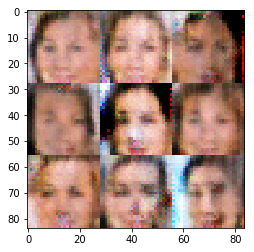

Epoch 1/1..., step 1010 Discriminator Loss: 1.3272... Generator Loss: 0.4027
Epoch 1/1..., step 1020 Discriminator Loss: 1.5611... Generator Loss: 0.3083
Epoch 1/1..., step 1030 Discriminator Loss: 1.4056... Generator Loss: 1.7461
Epoch 1/1..., step 1040 Discriminator Loss: 0.8958... Generator Loss: 1.0938
Epoch 1/1..., step 1050 Discriminator Loss: 1.3017... Generator Loss: 1.6765
Epoch 1/1..., step 1060 Discriminator Loss: 1.0282... Generator Loss: 0.7907
Epoch 1/1..., step 1070 Discriminator Loss: 1.5612... Generator Loss: 0.3091
Epoch 1/1..., step 1080 Discriminator Loss: 1.5109... Generator Loss: 0.7188
Epoch 1/1..., step 1090 Discriminator Loss: 1.0427... Generator Loss: 0.8446
Epoch 1/1..., step 1100 Discriminator Loss: 1.1820... Generator Loss: 0.8041


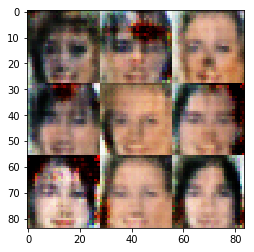

Epoch 1/1..., step 1110 Discriminator Loss: 1.4485... Generator Loss: 0.4308
Epoch 1/1..., step 1120 Discriminator Loss: 1.8500... Generator Loss: 2.2821
Epoch 1/1..., step 1130 Discriminator Loss: 1.6154... Generator Loss: 0.3381
Epoch 1/1..., step 1140 Discriminator Loss: 1.2269... Generator Loss: 0.9241
Epoch 1/1..., step 1150 Discriminator Loss: 0.9699... Generator Loss: 1.5412
Epoch 1/1..., step 1160 Discriminator Loss: 1.3224... Generator Loss: 0.3593
Epoch 1/1..., step 1170 Discriminator Loss: 0.9923... Generator Loss: 1.4359
Epoch 1/1..., step 1180 Discriminator Loss: 1.3789... Generator Loss: 1.4357
Epoch 1/1..., step 1190 Discriminator Loss: 1.4039... Generator Loss: 0.5613
Epoch 1/1..., step 1200 Discriminator Loss: 1.3655... Generator Loss: 0.6416


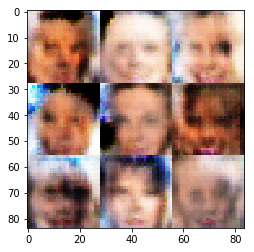

Epoch 1/1..., step 1210 Discriminator Loss: 1.5036... Generator Loss: 1.7262
Epoch 1/1..., step 1220 Discriminator Loss: 1.9716... Generator Loss: 0.2080
Epoch 1/1..., step 1230 Discriminator Loss: 1.2519... Generator Loss: 0.5711
Epoch 1/1..., step 1240 Discriminator Loss: 2.2529... Generator Loss: 0.1351
Epoch 1/1..., step 1250 Discriminator Loss: 1.1078... Generator Loss: 0.6312
Epoch 1/1..., step 1260 Discriminator Loss: 1.4930... Generator Loss: 0.7404
Epoch 1/1..., step 1270 Discriminator Loss: 1.2770... Generator Loss: 0.5984
Epoch 1/1..., step 1280 Discriminator Loss: 1.3160... Generator Loss: 0.8172
Epoch 1/1..., step 1290 Discriminator Loss: 1.4093... Generator Loss: 1.6121
Epoch 1/1..., step 1300 Discriminator Loss: 1.5888... Generator Loss: 0.3379


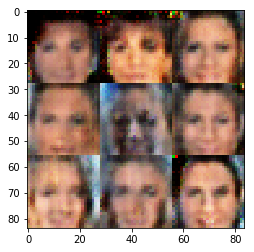

Epoch 1/1..., step 1310 Discriminator Loss: 1.3660... Generator Loss: 0.4635
Epoch 1/1..., step 1320 Discriminator Loss: 1.2219... Generator Loss: 0.6639
Epoch 1/1..., step 1330 Discriminator Loss: 1.2927... Generator Loss: 0.7066
Epoch 1/1..., step 1340 Discriminator Loss: 1.4675... Generator Loss: 0.3883
Epoch 1/1..., step 1350 Discriminator Loss: 1.2529... Generator Loss: 1.2354
Epoch 1/1..., step 1360 Discriminator Loss: 1.6323... Generator Loss: 0.9693
Epoch 1/1..., step 1370 Discriminator Loss: 1.8104... Generator Loss: 0.2488
Epoch 1/1..., step 1380 Discriminator Loss: 0.9126... Generator Loss: 1.7118
Epoch 1/1..., step 1390 Discriminator Loss: 1.0296... Generator Loss: 0.7114
Epoch 1/1..., step 1400 Discriminator Loss: 1.2180... Generator Loss: 0.5350


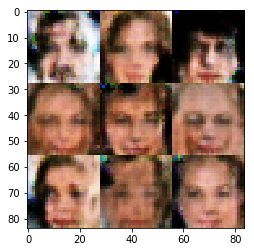

Epoch 1/1..., step 1410 Discriminator Loss: 1.2995... Generator Loss: 1.6381
Epoch 1/1..., step 1420 Discriminator Loss: 1.4759... Generator Loss: 0.3709
Epoch 1/1..., step 1430 Discriminator Loss: 1.5244... Generator Loss: 0.4766
Epoch 1/1..., step 1440 Discriminator Loss: 1.5396... Generator Loss: 1.2864
Epoch 1/1..., step 1450 Discriminator Loss: 0.9473... Generator Loss: 1.1103
Epoch 1/1..., step 1460 Discriminator Loss: 1.1150... Generator Loss: 0.9743
Epoch 1/1..., step 1470 Discriminator Loss: 1.0332... Generator Loss: 0.7845
Epoch 1/1..., step 1480 Discriminator Loss: 1.2423... Generator Loss: 0.8679
Epoch 1/1..., step 1490 Discriminator Loss: 1.2124... Generator Loss: 0.5425
Epoch 1/1..., step 1500 Discriminator Loss: 1.1687... Generator Loss: 1.4527


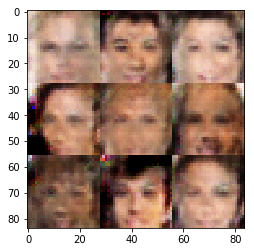

Epoch 1/1..., step 1510 Discriminator Loss: 1.0333... Generator Loss: 0.8339
Epoch 1/1..., step 1520 Discriminator Loss: 1.6907... Generator Loss: 0.5355
Epoch 1/1..., step 1530 Discriminator Loss: 1.2948... Generator Loss: 0.4314
Epoch 1/1..., step 1540 Discriminator Loss: 1.1716... Generator Loss: 0.9478
Epoch 1/1..., step 1550 Discriminator Loss: 1.9006... Generator Loss: 0.2559
Epoch 1/1..., step 1560 Discriminator Loss: 1.8490... Generator Loss: 2.4083
Epoch 1/1..., step 1570 Discriminator Loss: 0.9775... Generator Loss: 0.8196
Epoch 1/1..., step 1580 Discriminator Loss: 1.2119... Generator Loss: 0.8691
Epoch 1/1..., step 1590 Discriminator Loss: 1.2493... Generator Loss: 0.6002
Epoch 1/1..., step 1600 Discriminator Loss: 1.4531... Generator Loss: 0.3675


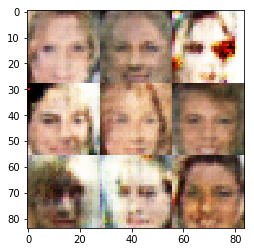

Epoch 1/1..., step 1610 Discriminator Loss: 1.3932... Generator Loss: 1.5572
Epoch 1/1..., step 1620 Discriminator Loss: 1.4737... Generator Loss: 0.3618
Epoch 1/1..., step 1630 Discriminator Loss: 1.0742... Generator Loss: 0.6034
Epoch 1/1..., step 1640 Discriminator Loss: 1.3682... Generator Loss: 0.4346
Epoch 1/1..., step 1650 Discriminator Loss: 1.0191... Generator Loss: 1.0333
Epoch 1/1..., step 1660 Discriminator Loss: 1.5732... Generator Loss: 0.3458
Epoch 1/1..., step 1670 Discriminator Loss: 1.2308... Generator Loss: 1.9420
Epoch 1/1..., step 1680 Discriminator Loss: 1.1687... Generator Loss: 0.7367
Epoch 1/1..., step 1690 Discriminator Loss: 1.3190... Generator Loss: 1.1821
Epoch 1/1..., step 1700 Discriminator Loss: 1.6987... Generator Loss: 0.3301


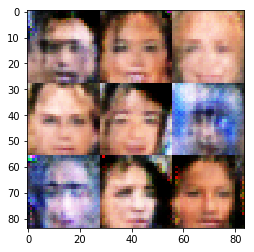

Epoch 1/1..., step 1710 Discriminator Loss: 1.5422... Generator Loss: 0.3504
Epoch 1/1..., step 1720 Discriminator Loss: 1.4768... Generator Loss: 0.5178
Epoch 1/1..., step 1730 Discriminator Loss: 1.4042... Generator Loss: 0.6130
Epoch 1/1..., step 1740 Discriminator Loss: 1.0313... Generator Loss: 0.7802
Epoch 1/1..., step 1750 Discriminator Loss: 1.2847... Generator Loss: 0.6264
Epoch 1/1..., step 1760 Discriminator Loss: 1.3965... Generator Loss: 0.4717
Epoch 1/1..., step 1770 Discriminator Loss: 0.8913... Generator Loss: 0.8944
Epoch 1/1..., step 1780 Discriminator Loss: 1.5405... Generator Loss: 1.9332
Epoch 1/1..., step 1790 Discriminator Loss: 1.1439... Generator Loss: 0.6606
Epoch 1/1..., step 1800 Discriminator Loss: 1.5452... Generator Loss: 0.3323


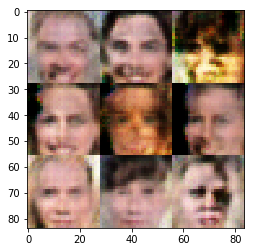

Epoch 1/1..., step 1810 Discriminator Loss: 1.1269... Generator Loss: 1.3814
Epoch 1/1..., step 1820 Discriminator Loss: 1.2431... Generator Loss: 0.5292
Epoch 1/1..., step 1830 Discriminator Loss: 1.2962... Generator Loss: 1.1915
Epoch 1/1..., step 1840 Discriminator Loss: 1.6266... Generator Loss: 1.0266
Epoch 1/1..., step 1850 Discriminator Loss: 1.0239... Generator Loss: 1.2768
Epoch 1/1..., step 1860 Discriminator Loss: 0.9307... Generator Loss: 0.9337
Epoch 1/1..., step 1870 Discriminator Loss: 1.1895... Generator Loss: 0.8311
Epoch 1/1..., step 1880 Discriminator Loss: 1.5557... Generator Loss: 1.0790
Epoch 1/1..., step 1890 Discriminator Loss: 1.4351... Generator Loss: 0.9977
Epoch 1/1..., step 1900 Discriminator Loss: 1.1488... Generator Loss: 0.9445


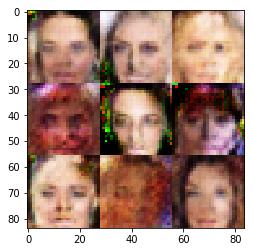

Epoch 1/1..., step 1910 Discriminator Loss: 1.1924... Generator Loss: 0.5097
Epoch 1/1..., step 1920 Discriminator Loss: 1.3667... Generator Loss: 1.3359
Epoch 1/1..., step 1930 Discriminator Loss: 1.3490... Generator Loss: 0.4066
Epoch 1/1..., step 1940 Discriminator Loss: 1.0190... Generator Loss: 0.7205
Epoch 1/1..., step 1950 Discriminator Loss: 1.1166... Generator Loss: 0.6103
Epoch 1/1..., step 1960 Discriminator Loss: 1.1557... Generator Loss: 0.5676
Epoch 1/1..., step 1970 Discriminator Loss: 1.4252... Generator Loss: 0.3412
Epoch 1/1..., step 1980 Discriminator Loss: 1.5321... Generator Loss: 0.3635
Epoch 1/1..., step 1990 Discriminator Loss: 1.1359... Generator Loss: 0.5960
Epoch 1/1..., step 2000 Discriminator Loss: 1.1422... Generator Loss: 0.7404


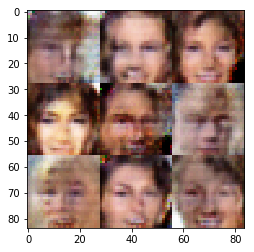

Epoch 1/1..., step 2010 Discriminator Loss: 1.0326... Generator Loss: 0.9211
Epoch 1/1..., step 2020 Discriminator Loss: 1.0661... Generator Loss: 0.8980
Epoch 1/1..., step 2030 Discriminator Loss: 1.5540... Generator Loss: 0.4014
Epoch 1/1..., step 2040 Discriminator Loss: 1.1731... Generator Loss: 0.6093
Epoch 1/1..., step 2050 Discriminator Loss: 1.4573... Generator Loss: 0.4570
Epoch 1/1..., step 2060 Discriminator Loss: 1.2147... Generator Loss: 0.5540
Epoch 1/1..., step 2070 Discriminator Loss: 1.3749... Generator Loss: 0.4287
Epoch 1/1..., step 2080 Discriminator Loss: 1.7058... Generator Loss: 0.2213
Epoch 1/1..., step 2090 Discriminator Loss: 0.9235... Generator Loss: 0.7623
Epoch 1/1..., step 2100 Discriminator Loss: 1.1631... Generator Loss: 0.5211


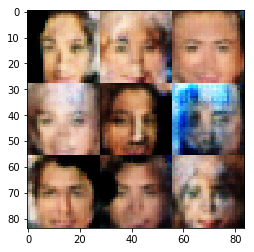

Epoch 1/1..., step 2110 Discriminator Loss: 1.2915... Generator Loss: 0.4790
Epoch 1/1..., step 2120 Discriminator Loss: 1.2382... Generator Loss: 1.2646
Epoch 1/1..., step 2130 Discriminator Loss: 1.1595... Generator Loss: 0.9656
Epoch 1/1..., step 2140 Discriminator Loss: 1.2116... Generator Loss: 0.5294
Epoch 1/1..., step 2150 Discriminator Loss: 1.1681... Generator Loss: 0.6578
Epoch 1/1..., step 2160 Discriminator Loss: 1.1775... Generator Loss: 0.6350
Epoch 1/1..., step 2170 Discriminator Loss: 1.6477... Generator Loss: 0.3019
Epoch 1/1..., step 2180 Discriminator Loss: 1.2065... Generator Loss: 0.7239
Epoch 1/1..., step 2190 Discriminator Loss: 1.0939... Generator Loss: 1.0525
Epoch 1/1..., step 2200 Discriminator Loss: 1.4979... Generator Loss: 0.4340


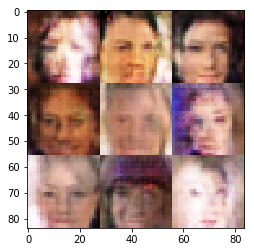

Epoch 1/1..., step 2210 Discriminator Loss: 1.3358... Generator Loss: 0.6467
Epoch 1/1..., step 2220 Discriminator Loss: 0.9955... Generator Loss: 0.8517
Epoch 1/1..., step 2230 Discriminator Loss: 1.2797... Generator Loss: 0.6588
Epoch 1/1..., step 2240 Discriminator Loss: 1.5332... Generator Loss: 0.3539
Epoch 1/1..., step 2250 Discriminator Loss: 1.0549... Generator Loss: 0.8699
Epoch 1/1..., step 2260 Discriminator Loss: 1.1354... Generator Loss: 1.0850
Epoch 1/1..., step 2270 Discriminator Loss: 1.2257... Generator Loss: 0.9525
Epoch 1/1..., step 2280 Discriminator Loss: 1.2308... Generator Loss: 0.5704
Epoch 1/1..., step 2290 Discriminator Loss: 1.6724... Generator Loss: 0.2824
Epoch 1/1..., step 2300 Discriminator Loss: 1.6537... Generator Loss: 0.2832


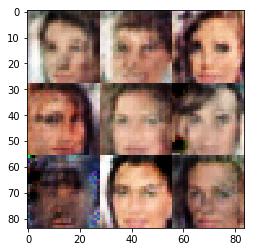

Epoch 1/1..., step 2310 Discriminator Loss: 0.7301... Generator Loss: 1.0689
Epoch 1/1..., step 2320 Discriminator Loss: 1.1602... Generator Loss: 0.6283
Epoch 1/1..., step 2330 Discriminator Loss: 1.6020... Generator Loss: 0.6177
Epoch 1/1..., step 2340 Discriminator Loss: 1.3067... Generator Loss: 0.6675
Epoch 1/1..., step 2350 Discriminator Loss: 1.3349... Generator Loss: 1.4251
Epoch 1/1..., step 2360 Discriminator Loss: 1.1460... Generator Loss: 1.1590
Epoch 1/1..., step 2370 Discriminator Loss: 1.4816... Generator Loss: 1.3249
Epoch 1/1..., step 2380 Discriminator Loss: 1.3488... Generator Loss: 0.5378
Epoch 1/1..., step 2390 Discriminator Loss: 1.0256... Generator Loss: 1.0650
Epoch 1/1..., step 2400 Discriminator Loss: 0.4637... Generator Loss: 1.6223


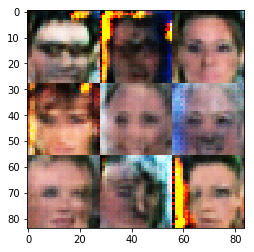

Epoch 1/1..., step 2410 Discriminator Loss: 1.0448... Generator Loss: 0.9585
Epoch 1/1..., step 2420 Discriminator Loss: 1.5079... Generator Loss: 1.0694
Epoch 1/1..., step 2430 Discriminator Loss: 1.8656... Generator Loss: 0.1976
Epoch 1/1..., step 2440 Discriminator Loss: 1.9142... Generator Loss: 0.2035
Epoch 1/1..., step 2450 Discriminator Loss: 1.1731... Generator Loss: 1.5267
Epoch 1/1..., step 2460 Discriminator Loss: 1.1394... Generator Loss: 0.5428
Epoch 1/1..., step 2470 Discriminator Loss: 0.8282... Generator Loss: 0.7767
Epoch 1/1..., step 2480 Discriminator Loss: 1.4733... Generator Loss: 0.3847
Epoch 1/1..., step 2490 Discriminator Loss: 1.0743... Generator Loss: 0.6198
Epoch 1/1..., step 2500 Discriminator Loss: 0.6290... Generator Loss: 1.2451


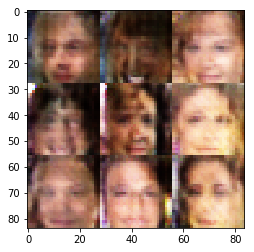

Epoch 1/1..., step 2510 Discriminator Loss: 0.2916... Generator Loss: 2.3506
Epoch 1/1..., step 2520 Discriminator Loss: 1.7839... Generator Loss: 0.3096
Epoch 1/1..., step 2530 Discriminator Loss: 1.3915... Generator Loss: 0.5179
Epoch 1/1..., step 2540 Discriminator Loss: 1.2350... Generator Loss: 0.7707
Epoch 1/1..., step 2550 Discriminator Loss: 0.7423... Generator Loss: 1.1057
Epoch 1/1..., step 2560 Discriminator Loss: 0.6201... Generator Loss: 1.0055
Epoch 1/1..., step 2570 Discriminator Loss: 1.0207... Generator Loss: 0.5767
Epoch 1/1..., step 2580 Discriminator Loss: 2.7449... Generator Loss: 3.2035
Epoch 1/1..., step 2590 Discriminator Loss: 1.1989... Generator Loss: 1.7232
Epoch 1/1..., step 2600 Discriminator Loss: 1.0020... Generator Loss: 0.8950


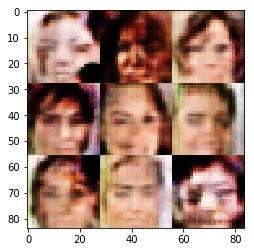

Epoch 1/1..., step 2610 Discriminator Loss: 1.2445... Generator Loss: 0.9285
Epoch 1/1..., step 2620 Discriminator Loss: 1.5843... Generator Loss: 0.3166
Epoch 1/1..., step 2630 Discriminator Loss: 1.3672... Generator Loss: 0.6417
Epoch 1/1..., step 2640 Discriminator Loss: 1.2812... Generator Loss: 0.5146
Epoch 1/1..., step 2650 Discriminator Loss: 1.3216... Generator Loss: 0.7179
Epoch 1/1..., step 2660 Discriminator Loss: 1.2606... Generator Loss: 0.6005
Epoch 1/1..., step 2670 Discriminator Loss: 1.1605... Generator Loss: 0.6111
Epoch 1/1..., step 2680 Discriminator Loss: 1.4900... Generator Loss: 1.2698
Epoch 1/1..., step 2690 Discriminator Loss: 1.2372... Generator Loss: 0.6860
Epoch 1/1..., step 2700 Discriminator Loss: 1.4248... Generator Loss: 0.6951


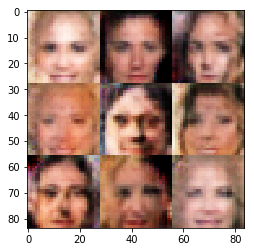

Epoch 1/1..., step 2710 Discriminator Loss: 1.3015... Generator Loss: 0.5528
Epoch 1/1..., step 2720 Discriminator Loss: 1.3464... Generator Loss: 0.7904
Epoch 1/1..., step 2730 Discriminator Loss: 0.9155... Generator Loss: 1.2096
Epoch 1/1..., step 2740 Discriminator Loss: 0.9018... Generator Loss: 0.8466
Epoch 1/1..., step 2750 Discriminator Loss: 1.8454... Generator Loss: 0.2560
Epoch 1/1..., step 2760 Discriminator Loss: 1.3325... Generator Loss: 0.7705
Epoch 1/1..., step 2770 Discriminator Loss: 1.4162... Generator Loss: 0.4384
Epoch 1/1..., step 2780 Discriminator Loss: 1.6271... Generator Loss: 0.9834
Epoch 1/1..., step 2790 Discriminator Loss: 1.2272... Generator Loss: 0.7391
Epoch 1/1..., step 2800 Discriminator Loss: 1.5202... Generator Loss: 1.3722


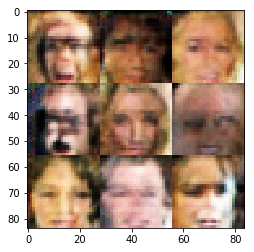

Epoch 1/1..., step 2810 Discriminator Loss: 1.2347... Generator Loss: 0.6070
Epoch 1/1..., step 2820 Discriminator Loss: 1.4360... Generator Loss: 0.5990
Epoch 1/1..., step 2830 Discriminator Loss: 1.2231... Generator Loss: 0.9401
Epoch 1/1..., step 2840 Discriminator Loss: 1.3600... Generator Loss: 0.6340
Epoch 1/1..., step 2850 Discriminator Loss: 1.3836... Generator Loss: 0.7747
Epoch 1/1..., step 2860 Discriminator Loss: 1.4610... Generator Loss: 0.4650
Epoch 1/1..., step 2870 Discriminator Loss: 1.0860... Generator Loss: 0.6705
Epoch 1/1..., step 2880 Discriminator Loss: 1.1760... Generator Loss: 0.9638
Epoch 1/1..., step 2890 Discriminator Loss: 0.7441... Generator Loss: 3.2777
Epoch 1/1..., step 2900 Discriminator Loss: 1.5062... Generator Loss: 0.4010


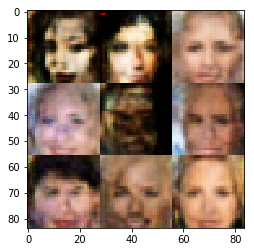

Epoch 1/1..., step 2910 Discriminator Loss: 1.5286... Generator Loss: 0.5473
Epoch 1/1..., step 2920 Discriminator Loss: 1.1292... Generator Loss: 0.8723
Epoch 1/1..., step 2930 Discriminator Loss: 1.2963... Generator Loss: 0.6534
Epoch 1/1..., step 2940 Discriminator Loss: 1.2580... Generator Loss: 0.5830
Epoch 1/1..., step 2950 Discriminator Loss: 1.0314... Generator Loss: 0.9062
Epoch 1/1..., step 2960 Discriminator Loss: 1.3875... Generator Loss: 0.4234
Epoch 1/1..., step 2970 Discriminator Loss: 1.5950... Generator Loss: 0.6108
Epoch 1/1..., step 2980 Discriminator Loss: 1.4302... Generator Loss: 0.5479
Epoch 1/1..., step 2990 Discriminator Loss: 1.4343... Generator Loss: 0.6180
Epoch 1/1..., step 3000 Discriminator Loss: 1.3440... Generator Loss: 0.6310


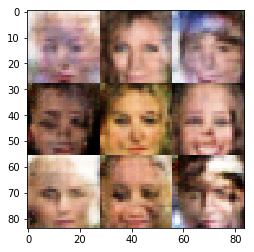

Epoch 1/1..., step 3010 Discriminator Loss: 1.4510... Generator Loss: 0.4878
Epoch 1/1..., step 3020 Discriminator Loss: 1.2517... Generator Loss: 0.7315
Epoch 1/1..., step 3030 Discriminator Loss: 1.3142... Generator Loss: 0.6366
Epoch 1/1..., step 3040 Discriminator Loss: 1.3306... Generator Loss: 0.4468
Epoch 1/1..., step 3050 Discriminator Loss: 1.3212... Generator Loss: 0.6918
Epoch 1/1..., step 3060 Discriminator Loss: 1.3737... Generator Loss: 0.5946
Epoch 1/1..., step 3070 Discriminator Loss: 1.3285... Generator Loss: 0.5147
Epoch 1/1..., step 3080 Discriminator Loss: 1.6325... Generator Loss: 0.3720
Epoch 1/1..., step 3090 Discriminator Loss: 1.2881... Generator Loss: 0.6274
Epoch 1/1..., step 3100 Discriminator Loss: 1.4333... Generator Loss: 0.5598


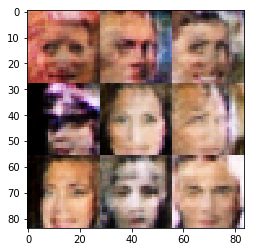

Epoch 1/1..., step 3110 Discriminator Loss: 1.3407... Generator Loss: 0.5894
Epoch 1/1..., step 3120 Discriminator Loss: 1.2234... Generator Loss: 0.7876
Epoch 1/1..., step 3130 Discriminator Loss: 1.2324... Generator Loss: 0.7366
Epoch 1/1..., step 3140 Discriminator Loss: 1.3277... Generator Loss: 0.6475
Epoch 1/1..., step 3150 Discriminator Loss: 1.2297... Generator Loss: 0.7559
Epoch 1/1..., step 3160 Discriminator Loss: 0.8390... Generator Loss: 1.1746
Epoch 1/1..., step 3170 Discriminator Loss: 1.5204... Generator Loss: 0.4131
Epoch 1/1..., step 3180 Discriminator Loss: 1.3361... Generator Loss: 0.6098
Epoch 1/1..., step 3190 Discriminator Loss: 1.2983... Generator Loss: 0.6388
Epoch 1/1..., step 3200 Discriminator Loss: 1.2800... Generator Loss: 0.5074


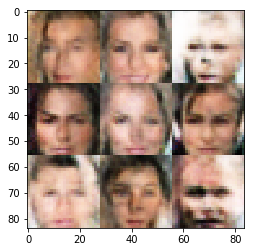

Epoch 1/1..., step 3210 Discriminator Loss: 1.2849... Generator Loss: 0.6953
Epoch 1/1..., step 3220 Discriminator Loss: 1.4194... Generator Loss: 0.6432
Epoch 1/1..., step 3230 Discriminator Loss: 1.3793... Generator Loss: 0.6065
Epoch 1/1..., step 3240 Discriminator Loss: 1.2178... Generator Loss: 0.7077
Epoch 1/1..., step 3250 Discriminator Loss: 1.3400... Generator Loss: 0.6406
Epoch 1/1..., step 3260 Discriminator Loss: 1.3238... Generator Loss: 0.5775
Epoch 1/1..., step 3270 Discriminator Loss: 1.4334... Generator Loss: 0.5791
Epoch 1/1..., step 3280 Discriminator Loss: 1.5555... Generator Loss: 0.4492
Epoch 1/1..., step 3290 Discriminator Loss: 1.4366... Generator Loss: 0.6076
Epoch 1/1..., step 3300 Discriminator Loss: 1.5719... Generator Loss: 0.4091


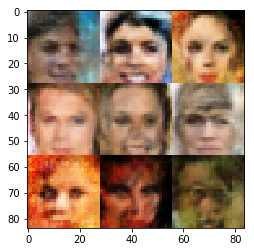

Epoch 1/1..., step 3310 Discriminator Loss: 1.4598... Generator Loss: 0.6193
Epoch 1/1..., step 3320 Discriminator Loss: 1.2232... Generator Loss: 0.6494
Epoch 1/1..., step 3330 Discriminator Loss: 1.3626... Generator Loss: 0.7124
Epoch 1/1..., step 3340 Discriminator Loss: 1.2356... Generator Loss: 0.6662
Epoch 1/1..., step 3350 Discriminator Loss: 1.2389... Generator Loss: 0.6460
Epoch 1/1..., step 3360 Discriminator Loss: 1.3998... Generator Loss: 0.5033
Epoch 1/1..., step 3370 Discriminator Loss: 1.3180... Generator Loss: 0.7559
Epoch 1/1..., step 3380 Discriminator Loss: 1.4519... Generator Loss: 0.5776
Epoch 1/1..., step 3390 Discriminator Loss: 1.2408... Generator Loss: 0.6530
Epoch 1/1..., step 3400 Discriminator Loss: 1.2427... Generator Loss: 0.7421


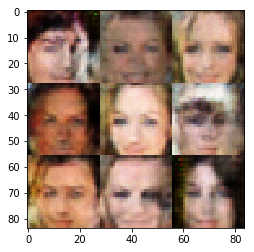

Epoch 1/1..., step 3410 Discriminator Loss: 1.4674... Generator Loss: 0.4858
Epoch 1/1..., step 3420 Discriminator Loss: 1.4513... Generator Loss: 0.6368
Epoch 1/1..., step 3430 Discriminator Loss: 1.5499... Generator Loss: 0.4438
Epoch 1/1..., step 3440 Discriminator Loss: 1.3683... Generator Loss: 0.4841
Epoch 1/1..., step 3450 Discriminator Loss: 1.3734... Generator Loss: 0.6070
Epoch 1/1..., step 3460 Discriminator Loss: 1.3302... Generator Loss: 0.6900
Epoch 1/1..., step 3470 Discriminator Loss: 1.3780... Generator Loss: 0.4806
Epoch 1/1..., step 3480 Discriminator Loss: 1.4037... Generator Loss: 0.4830
Epoch 1/1..., step 3490 Discriminator Loss: 1.1746... Generator Loss: 0.9735
Epoch 1/1..., step 3500 Discriminator Loss: 1.4103... Generator Loss: 0.5705


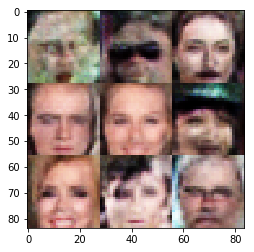

Epoch 1/1..., step 3510 Discriminator Loss: 1.1526... Generator Loss: 0.7327
Epoch 1/1..., step 3520 Discriminator Loss: 1.3029... Generator Loss: 0.6474
Epoch 1/1..., step 3530 Discriminator Loss: 1.4888... Generator Loss: 0.5681
Epoch 1/1..., step 3540 Discriminator Loss: 1.3988... Generator Loss: 0.5026
Epoch 1/1..., step 3550 Discriminator Loss: 1.0898... Generator Loss: 0.7541
Epoch 1/1..., step 3560 Discriminator Loss: 1.2226... Generator Loss: 0.6769
Epoch 1/1..., step 3570 Discriminator Loss: 1.3234... Generator Loss: 0.7203
Epoch 1/1..., step 3580 Discriminator Loss: 1.4451... Generator Loss: 0.4922
Epoch 1/1..., step 3590 Discriminator Loss: 1.3751... Generator Loss: 0.6337
Epoch 1/1..., step 3600 Discriminator Loss: 1.4882... Generator Loss: 0.4968


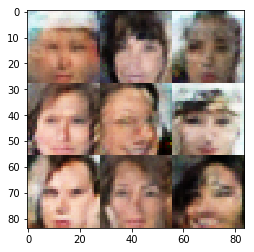

Epoch 1/1..., step 3610 Discriminator Loss: 1.3164... Generator Loss: 0.8527
Epoch 1/1..., step 3620 Discriminator Loss: 1.2656... Generator Loss: 0.7475
Epoch 1/1..., step 3630 Discriminator Loss: 1.3236... Generator Loss: 0.5616
Epoch 1/1..., step 3640 Discriminator Loss: 1.2790... Generator Loss: 0.7697
Epoch 1/1..., step 3650 Discriminator Loss: 1.2436... Generator Loss: 0.6934
Epoch 1/1..., step 3660 Discriminator Loss: 1.3780... Generator Loss: 0.6124
Epoch 1/1..., step 3670 Discriminator Loss: 1.3660... Generator Loss: 0.5343
Epoch 1/1..., step 3680 Discriminator Loss: 1.3661... Generator Loss: 0.5963
Epoch 1/1..., step 3690 Discriminator Loss: 1.3777... Generator Loss: 0.5005
Epoch 1/1..., step 3700 Discriminator Loss: 1.4078... Generator Loss: 0.5666


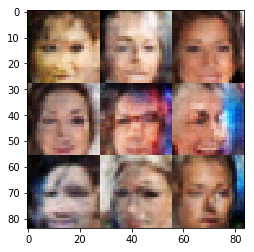

Epoch 1/1..., step 3710 Discriminator Loss: 1.4332... Generator Loss: 0.6294
Epoch 1/1..., step 3720 Discriminator Loss: 1.4064... Generator Loss: 0.5401
Epoch 1/1..., step 3730 Discriminator Loss: 1.3976... Generator Loss: 0.5167
Epoch 1/1..., step 3740 Discriminator Loss: 1.3823... Generator Loss: 0.5202
Epoch 1/1..., step 3750 Discriminator Loss: 1.2466... Generator Loss: 0.6851
Epoch 1/1..., step 3760 Discriminator Loss: 1.4377... Generator Loss: 0.6938
Epoch 1/1..., step 3770 Discriminator Loss: 1.4173... Generator Loss: 0.6597
Epoch 1/1..., step 3780 Discriminator Loss: 1.3628... Generator Loss: 0.6502
Epoch 1/1..., step 3790 Discriminator Loss: 1.4695... Generator Loss: 0.5926
Epoch 1/1..., step 3800 Discriminator Loss: 1.3245... Generator Loss: 0.6277


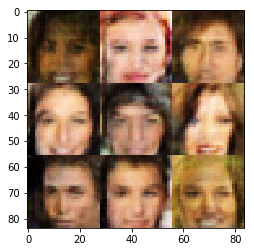

Epoch 1/1..., step 3810 Discriminator Loss: 1.4476... Generator Loss: 0.6138
Epoch 1/1..., step 3820 Discriminator Loss: 1.4005... Generator Loss: 0.6143
Epoch 1/1..., step 3830 Discriminator Loss: 1.4145... Generator Loss: 0.4655
Epoch 1/1..., step 3840 Discriminator Loss: 1.3228... Generator Loss: 0.4808
Epoch 1/1..., step 3850 Discriminator Loss: 1.2156... Generator Loss: 1.0536
Epoch 1/1..., step 3860 Discriminator Loss: 1.3673... Generator Loss: 0.5937
Epoch 1/1..., step 3870 Discriminator Loss: 1.4159... Generator Loss: 0.5909
Epoch 1/1..., step 3880 Discriminator Loss: 1.1900... Generator Loss: 0.8524
Epoch 1/1..., step 3890 Discriminator Loss: 1.3808... Generator Loss: 0.5870
Epoch 1/1..., step 3900 Discriminator Loss: 1.3664... Generator Loss: 0.7354


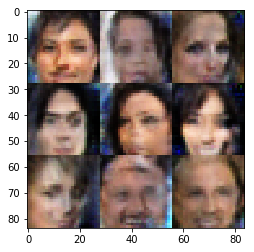

Epoch 1/1..., step 3910 Discriminator Loss: 1.2009... Generator Loss: 0.7777
Epoch 1/1..., step 3920 Discriminator Loss: 1.3468... Generator Loss: 0.6020
Epoch 1/1..., step 3930 Discriminator Loss: 1.3225... Generator Loss: 0.6425
Epoch 1/1..., step 3940 Discriminator Loss: 1.3222... Generator Loss: 0.6855
Epoch 1/1..., step 3950 Discriminator Loss: 1.2561... Generator Loss: 0.7648
Epoch 1/1..., step 3960 Discriminator Loss: 1.3389... Generator Loss: 0.6804
Epoch 1/1..., step 3970 Discriminator Loss: 1.2793... Generator Loss: 0.7338
Epoch 1/1..., step 3980 Discriminator Loss: 1.4388... Generator Loss: 0.5077
Epoch 1/1..., step 3990 Discriminator Loss: 1.3736... Generator Loss: 0.5989
Epoch 1/1..., step 4000 Discriminator Loss: 1.2360... Generator Loss: 0.6113


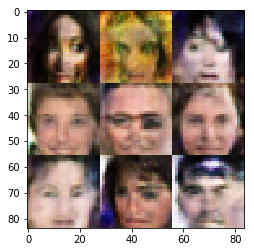

Epoch 1/1..., step 4010 Discriminator Loss: 1.4831... Generator Loss: 0.6362
Epoch 1/1..., step 4020 Discriminator Loss: 1.3352... Generator Loss: 0.5060
Epoch 1/1..., step 4030 Discriminator Loss: 1.3173... Generator Loss: 0.6842
Epoch 1/1..., step 4040 Discriminator Loss: 1.3429... Generator Loss: 0.5741
Epoch 1/1..., step 4050 Discriminator Loss: 1.4075... Generator Loss: 0.5971
Epoch 1/1..., step 4060 Discriminator Loss: 1.2640... Generator Loss: 0.7596
Epoch 1/1..., step 4070 Discriminator Loss: 1.3979... Generator Loss: 0.7191
Epoch 1/1..., step 4080 Discriminator Loss: 1.4212... Generator Loss: 0.4430
Epoch 1/1..., step 4090 Discriminator Loss: 1.2415... Generator Loss: 0.8503
Epoch 1/1..., step 4100 Discriminator Loss: 1.3948... Generator Loss: 0.5747


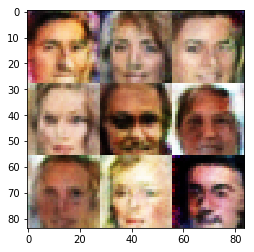

Epoch 1/1..., step 4110 Discriminator Loss: 1.3402... Generator Loss: 0.7918
Epoch 1/1..., step 4120 Discriminator Loss: 1.3212... Generator Loss: 0.6030
Epoch 1/1..., step 4130 Discriminator Loss: 1.2031... Generator Loss: 0.7231
Epoch 1/1..., step 4140 Discriminator Loss: 1.5896... Generator Loss: 0.5850
Epoch 1/1..., step 4150 Discriminator Loss: 1.3054... Generator Loss: 0.6770
Epoch 1/1..., step 4160 Discriminator Loss: 1.3148... Generator Loss: 0.8425
Epoch 1/1..., step 4170 Discriminator Loss: 1.2809... Generator Loss: 0.6002
Epoch 1/1..., step 4180 Discriminator Loss: 1.4465... Generator Loss: 0.5276
Epoch 1/1..., step 4190 Discriminator Loss: 1.3790... Generator Loss: 0.4824
Epoch 1/1..., step 4200 Discriminator Loss: 1.2277... Generator Loss: 0.6803


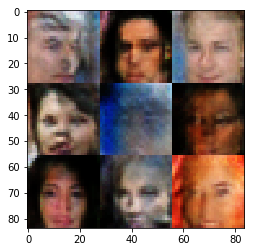

Epoch 1/1..., step 4210 Discriminator Loss: 1.3982... Generator Loss: 0.6062
Epoch 1/1..., step 4220 Discriminator Loss: 1.3434... Generator Loss: 0.6349
Epoch 1/1..., step 4230 Discriminator Loss: 1.3966... Generator Loss: 0.5133
Epoch 1/1..., step 4240 Discriminator Loss: 1.3077... Generator Loss: 0.6512
Epoch 1/1..., step 4250 Discriminator Loss: 1.3158... Generator Loss: 0.6870
Epoch 1/1..., step 4260 Discriminator Loss: 1.3908... Generator Loss: 0.6221
Epoch 1/1..., step 4270 Discriminator Loss: 1.3706... Generator Loss: 0.7089
Epoch 1/1..., step 4280 Discriminator Loss: 1.4377... Generator Loss: 0.5385
Epoch 1/1..., step 4290 Discriminator Loss: 1.3985... Generator Loss: 0.6161
Epoch 1/1..., step 4300 Discriminator Loss: 1.4342... Generator Loss: 0.4938


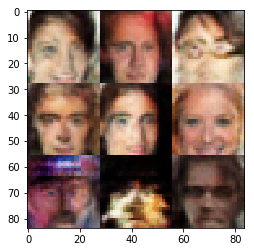

Epoch 1/1..., step 4310 Discriminator Loss: 1.2315... Generator Loss: 0.6554
Epoch 1/1..., step 4320 Discriminator Loss: 1.3538... Generator Loss: 0.6270
Epoch 1/1..., step 4330 Discriminator Loss: 1.3822... Generator Loss: 0.5398
Epoch 1/1..., step 4340 Discriminator Loss: 1.3324... Generator Loss: 0.6246
Epoch 1/1..., step 4350 Discriminator Loss: 1.3217... Generator Loss: 0.6956
Epoch 1/1..., step 4360 Discriminator Loss: 1.3524... Generator Loss: 0.6286
Epoch 1/1..., step 4370 Discriminator Loss: 1.4410... Generator Loss: 0.4988
Epoch 1/1..., step 4380 Discriminator Loss: 1.3758... Generator Loss: 0.6411
Epoch 1/1..., step 4390 Discriminator Loss: 1.3771... Generator Loss: 0.5023
Epoch 1/1..., step 4400 Discriminator Loss: 1.2717... Generator Loss: 0.6344


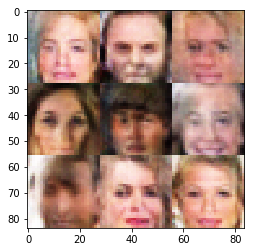

Epoch 1/1..., step 4410 Discriminator Loss: 1.3847... Generator Loss: 0.6669
Epoch 1/1..., step 4420 Discriminator Loss: 1.3408... Generator Loss: 0.6013
Epoch 1/1..., step 4430 Discriminator Loss: 1.4917... Generator Loss: 0.4158
Epoch 1/1..., step 4440 Discriminator Loss: 1.3795... Generator Loss: 0.6335
Epoch 1/1..., step 4450 Discriminator Loss: 1.3091... Generator Loss: 0.6050
Epoch 1/1..., step 4460 Discriminator Loss: 1.2995... Generator Loss: 0.6807
Epoch 1/1..., step 4470 Discriminator Loss: 1.2790... Generator Loss: 0.6406
Epoch 1/1..., step 4480 Discriminator Loss: 1.4552... Generator Loss: 0.5249
Epoch 1/1..., step 4490 Discriminator Loss: 1.2911... Generator Loss: 0.5829
Epoch 1/1..., step 4500 Discriminator Loss: 1.2238... Generator Loss: 0.8366


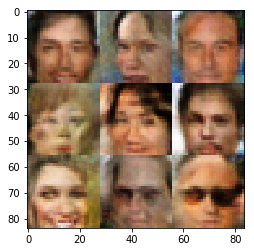

Epoch 1/1..., step 4510 Discriminator Loss: 1.4133... Generator Loss: 0.5644
Epoch 1/1..., step 4520 Discriminator Loss: 1.3423... Generator Loss: 0.5913
Epoch 1/1..., step 4530 Discriminator Loss: 1.4614... Generator Loss: 0.5502
Epoch 1/1..., step 4540 Discriminator Loss: 1.2799... Generator Loss: 0.7309
Epoch 1/1..., step 4550 Discriminator Loss: 1.4020... Generator Loss: 0.6146
Epoch 1/1..., step 4560 Discriminator Loss: 1.3810... Generator Loss: 0.5536
Epoch 1/1..., step 4570 Discriminator Loss: 1.5324... Generator Loss: 0.5517
Epoch 1/1..., step 4580 Discriminator Loss: 1.2595... Generator Loss: 0.7789
Epoch 1/1..., step 4590 Discriminator Loss: 1.3102... Generator Loss: 0.5964
Epoch 1/1..., step 4600 Discriminator Loss: 1.4813... Generator Loss: 0.5834


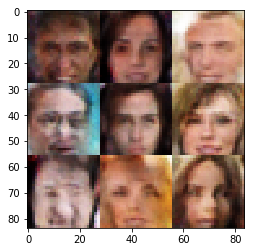

Epoch 1/1..., step 4610 Discriminator Loss: 1.3373... Generator Loss: 0.5954
Epoch 1/1..., step 4620 Discriminator Loss: 1.4044... Generator Loss: 0.9403
Epoch 1/1..., step 4630 Discriminator Loss: 1.4818... Generator Loss: 0.5206
Epoch 1/1..., step 4640 Discriminator Loss: 1.3915... Generator Loss: 0.6137
Epoch 1/1..., step 4650 Discriminator Loss: 1.3748... Generator Loss: 0.4965
Epoch 1/1..., step 4660 Discriminator Loss: 1.4361... Generator Loss: 0.6939
Epoch 1/1..., step 4670 Discriminator Loss: 1.3116... Generator Loss: 0.5460
Epoch 1/1..., step 4680 Discriminator Loss: 1.3320... Generator Loss: 0.8246
Epoch 1/1..., step 4690 Discriminator Loss: 1.2536... Generator Loss: 0.8297
Epoch 1/1..., step 4700 Discriminator Loss: 1.3465... Generator Loss: 0.6227


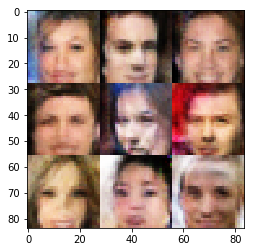

Epoch 1/1..., step 4710 Discriminator Loss: 1.2862... Generator Loss: 0.6846
Epoch 1/1..., step 4720 Discriminator Loss: 1.3695... Generator Loss: 0.7081
Epoch 1/1..., step 4730 Discriminator Loss: 1.3516... Generator Loss: 0.7585
Epoch 1/1..., step 4740 Discriminator Loss: 1.3349... Generator Loss: 0.6763
Epoch 1/1..., step 4750 Discriminator Loss: 1.3618... Generator Loss: 0.7304
Epoch 1/1..., step 4760 Discriminator Loss: 1.2448... Generator Loss: 0.6478
Epoch 1/1..., step 4770 Discriminator Loss: 1.3968... Generator Loss: 0.8713
Epoch 1/1..., step 4780 Discriminator Loss: 1.2907... Generator Loss: 0.6777
Epoch 1/1..., step 4790 Discriminator Loss: 1.4017... Generator Loss: 0.5477
Epoch 1/1..., step 4800 Discriminator Loss: 1.3473... Generator Loss: 0.7388


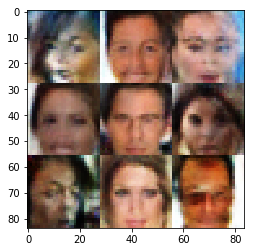

Epoch 1/1..., step 4810 Discriminator Loss: 1.3960... Generator Loss: 0.5741
Epoch 1/1..., step 4820 Discriminator Loss: 1.1985... Generator Loss: 0.7765
Epoch 1/1..., step 4830 Discriminator Loss: 1.3296... Generator Loss: 0.6153
Epoch 1/1..., step 4840 Discriminator Loss: 1.3581... Generator Loss: 0.6453
Epoch 1/1..., step 4850 Discriminator Loss: 1.2341... Generator Loss: 0.7045
Epoch 1/1..., step 4860 Discriminator Loss: 1.3430... Generator Loss: 0.6220
Epoch 1/1..., step 4870 Discriminator Loss: 1.3305... Generator Loss: 0.5873
Epoch 1/1..., step 4880 Discriminator Loss: 1.3306... Generator Loss: 0.6612
Epoch 1/1..., step 4890 Discriminator Loss: 1.5187... Generator Loss: 0.5673
Epoch 1/1..., step 4900 Discriminator Loss: 1.1808... Generator Loss: 0.7360


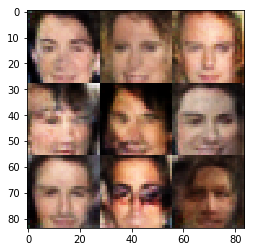

Epoch 1/1..., step 4910 Discriminator Loss: 1.1600... Generator Loss: 0.8377
Epoch 1/1..., step 4920 Discriminator Loss: 1.3579... Generator Loss: 0.6445
Epoch 1/1..., step 4930 Discriminator Loss: 1.3547... Generator Loss: 0.5689
Epoch 1/1..., step 4940 Discriminator Loss: 1.2715... Generator Loss: 0.7063
Epoch 1/1..., step 4950 Discriminator Loss: 1.2853... Generator Loss: 0.7012
Epoch 1/1..., step 4960 Discriminator Loss: 1.5427... Generator Loss: 0.5065
Epoch 1/1..., step 4970 Discriminator Loss: 1.3424... Generator Loss: 0.5727
Epoch 1/1..., step 4980 Discriminator Loss: 1.1758... Generator Loss: 0.8492
Epoch 1/1..., step 4990 Discriminator Loss: 1.3701... Generator Loss: 0.7099
Epoch 1/1..., step 5000 Discriminator Loss: 1.3655... Generator Loss: 0.5963


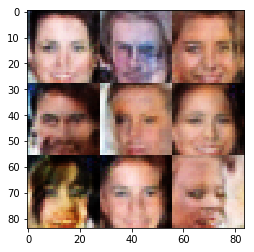

Epoch 1/1..., step 5010 Discriminator Loss: 1.3490... Generator Loss: 0.8108
Epoch 1/1..., step 5020 Discriminator Loss: 1.4466... Generator Loss: 0.6937
Epoch 1/1..., step 5030 Discriminator Loss: 1.2970... Generator Loss: 0.6423
Epoch 1/1..., step 5040 Discriminator Loss: 1.4127... Generator Loss: 0.5690
Epoch 1/1..., step 5050 Discriminator Loss: 1.2900... Generator Loss: 0.8561
Epoch 1/1..., step 5060 Discriminator Loss: 1.2839... Generator Loss: 0.5751
Epoch 1/1..., step 5070 Discriminator Loss: 1.3865... Generator Loss: 0.8559
Epoch 1/1..., step 5080 Discriminator Loss: 1.3541... Generator Loss: 0.7146
Epoch 1/1..., step 5090 Discriminator Loss: 1.3408... Generator Loss: 0.6780
Epoch 1/1..., step 5100 Discriminator Loss: 1.3207... Generator Loss: 0.7083


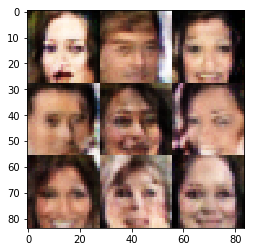

Epoch 1/1..., step 5110 Discriminator Loss: 1.4795... Generator Loss: 0.5608
Epoch 1/1..., step 5120 Discriminator Loss: 1.3484... Generator Loss: 0.6933
Epoch 1/1..., step 5130 Discriminator Loss: 1.4384... Generator Loss: 0.5223
Epoch 1/1..., step 5140 Discriminator Loss: 1.3243... Generator Loss: 0.6156
Epoch 1/1..., step 5150 Discriminator Loss: 1.2710... Generator Loss: 0.7693
Epoch 1/1..., step 5160 Discriminator Loss: 1.4247... Generator Loss: 0.4995
Epoch 1/1..., step 5170 Discriminator Loss: 1.2601... Generator Loss: 0.7738
Epoch 1/1..., step 5180 Discriminator Loss: 1.2856... Generator Loss: 0.6309
Epoch 1/1..., step 5190 Discriminator Loss: 1.3064... Generator Loss: 0.6526
Epoch 1/1..., step 5200 Discriminator Loss: 1.2515... Generator Loss: 0.7152


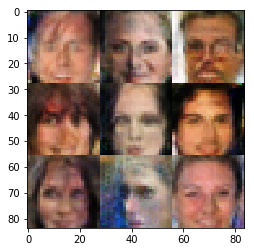

Epoch 1/1..., step 5210 Discriminator Loss: 1.3807... Generator Loss: 0.5909
Epoch 1/1..., step 5220 Discriminator Loss: 1.2769... Generator Loss: 0.7239
Epoch 1/1..., step 5230 Discriminator Loss: 1.2970... Generator Loss: 0.7539
Epoch 1/1..., step 5240 Discriminator Loss: 1.4608... Generator Loss: 0.5632
Epoch 1/1..., step 5250 Discriminator Loss: 1.3399... Generator Loss: 0.6502
Epoch 1/1..., step 5260 Discriminator Loss: 1.2734... Generator Loss: 0.6129
Epoch 1/1..., step 5270 Discriminator Loss: 1.4021... Generator Loss: 0.5961
Epoch 1/1..., step 5280 Discriminator Loss: 1.4046... Generator Loss: 0.6028
Epoch 1/1..., step 5290 Discriminator Loss: 1.2877... Generator Loss: 0.6729
Epoch 1/1..., step 5300 Discriminator Loss: 1.3659... Generator Loss: 0.6894


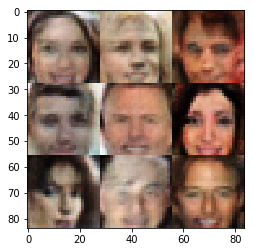

Epoch 1/1..., step 5310 Discriminator Loss: 1.3328... Generator Loss: 0.7318
Epoch 1/1..., step 5320 Discriminator Loss: 1.2257... Generator Loss: 0.6826
Epoch 1/1..., step 5330 Discriminator Loss: 1.4262... Generator Loss: 0.5835
Epoch 1/1..., step 5340 Discriminator Loss: 1.5095... Generator Loss: 0.6286
Epoch 1/1..., step 5350 Discriminator Loss: 1.2714... Generator Loss: 0.6467
Epoch 1/1..., step 5360 Discriminator Loss: 1.4072... Generator Loss: 0.6806
Epoch 1/1..., step 5370 Discriminator Loss: 1.4352... Generator Loss: 0.6572
Epoch 1/1..., step 5380 Discriminator Loss: 1.3854... Generator Loss: 0.5775
Epoch 1/1..., step 5390 Discriminator Loss: 1.3540... Generator Loss: 0.6544
Epoch 1/1..., step 5400 Discriminator Loss: 1.3684... Generator Loss: 0.6543


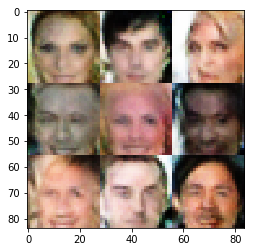

Epoch 1/1..., step 5410 Discriminator Loss: 1.3823... Generator Loss: 0.6240
Epoch 1/1..., step 5420 Discriminator Loss: 1.4062... Generator Loss: 0.6827
Epoch 1/1..., step 5430 Discriminator Loss: 1.4180... Generator Loss: 0.6385
Epoch 1/1..., step 5440 Discriminator Loss: 1.4498... Generator Loss: 0.4666
Epoch 1/1..., step 5450 Discriminator Loss: 1.2418... Generator Loss: 0.5683
Epoch 1/1..., step 5460 Discriminator Loss: 1.4783... Generator Loss: 0.5675
Epoch 1/1..., step 5470 Discriminator Loss: 1.4219... Generator Loss: 0.5180
Epoch 1/1..., step 5480 Discriminator Loss: 1.2170... Generator Loss: 0.6441
Epoch 1/1..., step 5490 Discriminator Loss: 1.3579... Generator Loss: 0.5611
Epoch 1/1..., step 5500 Discriminator Loss: 1.5349... Generator Loss: 0.6785


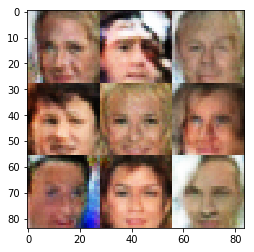

Epoch 1/1..., step 5510 Discriminator Loss: 1.4249... Generator Loss: 0.5471
Epoch 1/1..., step 5520 Discriminator Loss: 1.4129... Generator Loss: 0.5039
Epoch 1/1..., step 5530 Discriminator Loss: 1.4486... Generator Loss: 0.5507
Epoch 1/1..., step 5540 Discriminator Loss: 1.4347... Generator Loss: 0.5639
Epoch 1/1..., step 5550 Discriminator Loss: 1.4893... Generator Loss: 0.5586
Epoch 1/1..., step 5560 Discriminator Loss: 1.3714... Generator Loss: 0.6860
Epoch 1/1..., step 5570 Discriminator Loss: 1.3571... Generator Loss: 0.4923
Epoch 1/1..., step 5580 Discriminator Loss: 1.4596... Generator Loss: 0.5762
Epoch 1/1..., step 5590 Discriminator Loss: 1.2828... Generator Loss: 0.7096
Epoch 1/1..., step 5600 Discriminator Loss: 1.3427... Generator Loss: 0.6817


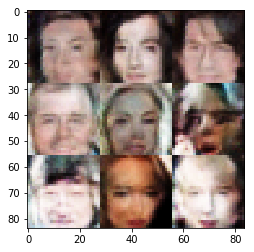

Epoch 1/1..., step 5610 Discriminator Loss: 1.3980... Generator Loss: 0.5173
Epoch 1/1..., step 5620 Discriminator Loss: 1.3602... Generator Loss: 0.6816
Epoch 1/1..., step 5630 Discriminator Loss: 1.3004... Generator Loss: 0.6566
Epoch 1/1..., step 5640 Discriminator Loss: 1.3120... Generator Loss: 0.6850
Epoch 1/1..., step 5650 Discriminator Loss: 1.4281... Generator Loss: 0.4914
Epoch 1/1..., step 5660 Discriminator Loss: 1.4391... Generator Loss: 0.5426
Epoch 1/1..., step 5670 Discriminator Loss: 1.4389... Generator Loss: 0.5655
Epoch 1/1..., step 5680 Discriminator Loss: 1.3156... Generator Loss: 0.6370
Epoch 1/1..., step 5690 Discriminator Loss: 1.3699... Generator Loss: 0.7506
Epoch 1/1..., step 5700 Discriminator Loss: 1.4047... Generator Loss: 0.7468


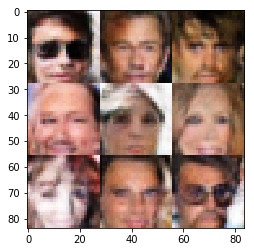

Epoch 1/1..., step 5710 Discriminator Loss: 1.3165... Generator Loss: 0.6522
Epoch 1/1..., step 5720 Discriminator Loss: 1.3989... Generator Loss: 0.5981
Epoch 1/1..., step 5730 Discriminator Loss: 1.1011... Generator Loss: 0.9365
Epoch 1/1..., step 5740 Discriminator Loss: 1.4307... Generator Loss: 0.4444
Epoch 1/1..., step 5750 Discriminator Loss: 1.3221... Generator Loss: 0.6413
Epoch 1/1..., step 5760 Discriminator Loss: 1.3924... Generator Loss: 0.7099
Epoch 1/1..., step 5770 Discriminator Loss: 1.4498... Generator Loss: 0.6793
Epoch 1/1..., step 5780 Discriminator Loss: 1.3736... Generator Loss: 0.8665
Epoch 1/1..., step 5790 Discriminator Loss: 1.3490... Generator Loss: 0.6594
Epoch 1/1..., step 5800 Discriminator Loss: 1.4048... Generator Loss: 0.5454


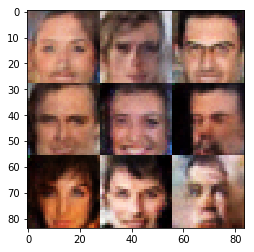

Epoch 1/1..., step 5810 Discriminator Loss: 1.3990... Generator Loss: 0.6495
Epoch 1/1..., step 5820 Discriminator Loss: 1.3697... Generator Loss: 0.5742
Epoch 1/1..., step 5830 Discriminator Loss: 1.5652... Generator Loss: 0.4836
Epoch 1/1..., step 5840 Discriminator Loss: 1.3617... Generator Loss: 0.5991
Epoch 1/1..., step 5850 Discriminator Loss: 1.2837... Generator Loss: 0.7211
Epoch 1/1..., step 5860 Discriminator Loss: 1.2838... Generator Loss: 0.5799
Epoch 1/1..., step 5870 Discriminator Loss: 1.4171... Generator Loss: 0.7551
Epoch 1/1..., step 5880 Discriminator Loss: 1.3470... Generator Loss: 0.5724
Epoch 1/1..., step 5890 Discriminator Loss: 1.4528... Generator Loss: 0.6120
Epoch 1/1..., step 5900 Discriminator Loss: 1.2891... Generator Loss: 0.5766


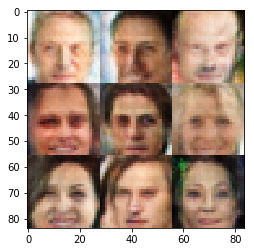

Epoch 1/1..., step 5910 Discriminator Loss: 1.3493... Generator Loss: 0.5146
Epoch 1/1..., step 5920 Discriminator Loss: 1.3341... Generator Loss: 0.5947
Epoch 1/1..., step 5930 Discriminator Loss: 1.4251... Generator Loss: 0.4637
Epoch 1/1..., step 5940 Discriminator Loss: 1.3531... Generator Loss: 0.6624
Epoch 1/1..., step 5950 Discriminator Loss: 1.3946... Generator Loss: 0.7293
Epoch 1/1..., step 5960 Discriminator Loss: 1.4977... Generator Loss: 0.5281
Epoch 1/1..., step 5970 Discriminator Loss: 1.3343... Generator Loss: 0.7338
Epoch 1/1..., step 5980 Discriminator Loss: 1.3443... Generator Loss: 0.6048
Epoch 1/1..., step 5990 Discriminator Loss: 1.4013... Generator Loss: 0.4694
Epoch 1/1..., step 6000 Discriminator Loss: 1.3667... Generator Loss: 0.5873


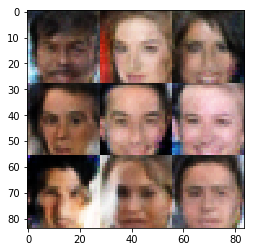

Epoch 1/1..., step 6010 Discriminator Loss: 1.2569... Generator Loss: 0.6335
Epoch 1/1..., step 6020 Discriminator Loss: 1.4571... Generator Loss: 0.6656
Epoch 1/1..., step 6030 Discriminator Loss: 1.3421... Generator Loss: 0.6751
Epoch 1/1..., step 6040 Discriminator Loss: 1.4204... Generator Loss: 0.6471
Epoch 1/1..., step 6050 Discriminator Loss: 1.3710... Generator Loss: 0.7118
Epoch 1/1..., step 6060 Discriminator Loss: 1.2767... Generator Loss: 0.6749
Epoch 1/1..., step 6070 Discriminator Loss: 1.3915... Generator Loss: 0.6778
Epoch 1/1..., step 6080 Discriminator Loss: 1.4530... Generator Loss: 0.5490
Epoch 1/1..., step 6090 Discriminator Loss: 1.4159... Generator Loss: 0.5661
Epoch 1/1..., step 6100 Discriminator Loss: 1.3881... Generator Loss: 0.8484


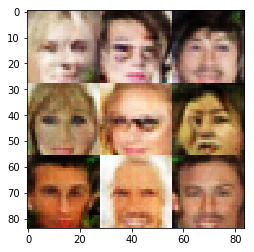

Epoch 1/1..., step 6110 Discriminator Loss: 1.4062... Generator Loss: 0.5368
Epoch 1/1..., step 6120 Discriminator Loss: 1.4030... Generator Loss: 0.5326
Epoch 1/1..., step 6130 Discriminator Loss: 1.3478... Generator Loss: 0.6398
Epoch 1/1..., step 6140 Discriminator Loss: 1.3251... Generator Loss: 0.5498
Epoch 1/1..., step 6150 Discriminator Loss: 1.2683... Generator Loss: 0.6999
Epoch 1/1..., step 6160 Discriminator Loss: 1.2388... Generator Loss: 0.8453
Epoch 1/1..., step 6170 Discriminator Loss: 1.2238... Generator Loss: 0.6456
Epoch 1/1..., step 6180 Discriminator Loss: 1.3843... Generator Loss: 0.5618
Epoch 1/1..., step 6190 Discriminator Loss: 1.2871... Generator Loss: 0.5974
Epoch 1/1..., step 6200 Discriminator Loss: 1.3996... Generator Loss: 0.6163


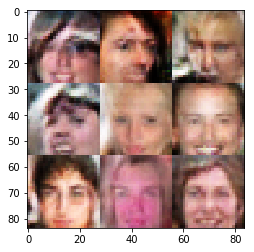

Epoch 1/1..., step 6210 Discriminator Loss: 1.3193... Generator Loss: 0.5519
Epoch 1/1..., step 6220 Discriminator Loss: 1.3478... Generator Loss: 0.6457
Epoch 1/1..., step 6230 Discriminator Loss: 1.3401... Generator Loss: 0.5180
Epoch 1/1..., step 6240 Discriminator Loss: 1.2822... Generator Loss: 0.7300
Epoch 1/1..., step 6250 Discriminator Loss: 1.5349... Generator Loss: 0.5761
Epoch 1/1..., step 6260 Discriminator Loss: 1.2808... Generator Loss: 0.6091
Epoch 1/1..., step 6270 Discriminator Loss: 1.5212... Generator Loss: 0.6673
Epoch 1/1..., step 6280 Discriminator Loss: 1.4027... Generator Loss: 0.7062
Epoch 1/1..., step 6290 Discriminator Loss: 1.3448... Generator Loss: 0.5737
Epoch 1/1..., step 6300 Discriminator Loss: 1.3357... Generator Loss: 0.6648


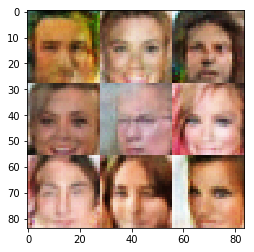

Epoch 1/1..., step 6310 Discriminator Loss: 1.4112... Generator Loss: 0.7492
Epoch 1/1..., step 6320 Discriminator Loss: 1.6532... Generator Loss: 0.4470
Epoch 1/1..., step 6330 Discriminator Loss: 1.4379... Generator Loss: 0.5223


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0009
beta1 = 0.4




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
  celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.